# Проект. Госпитализация. Анализ данных медицинского центра

## Описание проекта

Заказчик хочет построить ML модель для прогноза загрузки койко-мест, поэтому требуется выявить факторы, которые можно использовать для обучения создаваемой модели. 

### Описание данных

Таблица beds:

- referral_date - Дата выдачи направления на лечение пациенту

- income_date - Дата поступления пациента в отделение

- outcome_date - Дата выписки пациента из отделения

- user_id - Идентификатор пациента

- is_num - Системное поле (номер информационной безопасности)

- code - Системное поле

- region - Регион проживания пациента

- payer - Наименование платетельщика

- fin_source - ОМС или другой вариант

- dept - Название отделения

- profile - Профиль отделения (терапия, хирургия и т.д.)

- bed_days - Сколько дней лечения в стационаре у пациента

- is_plan - Поступил планово или экстренно

- income_mkb - Код диагноза при поступлении

- outcome_mkb -Код диагноза при выписке

## Изучение и подготовка данных данных

### Загрузка данных и подготовка их к анализу

In [1]:
!pip install phik

In [2]:
import pandas as pd
from pandas import Series, DataFrame
from scipy import stats as st
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import plotly.express as px
from plotly import graph_objects as go
import json
from folium.plugins import MarkerCluster
import folium
import phik
import psycopg2
import time
import warnings
warnings.filterwarnings('ignore')

# загружаем необходимые библиотеки

In [3]:
beds_connection = psycopg2.connect(dbname = 'hospital_db', user = 'student', 
                                                                                                                     password = 'uvBbBm8gn', host = '158.160.146.146',port = '5432')

In [4]:
beds = pd.read_sql('SELECT * FROM beds;', con = beds_connection)

In [5]:
beds.head(5)
# открываем первые 5 строк

,index,referral_date,income_date,outcome_date,user_id,is_num,code,region,payer,fin_source,dept,profile,bed_days,is_plan,income_mkb,outcome_mkb
0,0,None,01.01.2019,10.01.2019,858042000.0,1,5.4.1,None,"ОАО ""ГСМК"" СПб",ОМС,Микрохирургическое отделение,Сосудистой хирургии,10.0,Экстренная,S61.7,S66.4
1,1,None,01.01.2019,01.01.2019,993109000.0,3,5.13.1,None,"СПб филиал ООО ""СМК РЕСО - Мед""",ОМС,Хирургическое отделение №3,Гнойные хирургические,1.0,Экстренная,K37,K63.8
2,2,None,01.01.2019,01.01.2019,993111000.0,4,5.12.1,None,"ООО ""Капитал Медицинское Страхование""",ОМС,Хирургическое отделение №3,Гнойные хирургические,1.0,Экстренная,K37,K63.8
3,3,None,01.01.2019,07.01.2019,993110000.0,2,5.4.1,None,"ОАО ""ГСМК"" СПб",ОМС,Инфекционное отделение №1,Инфекционные,7.0,Экстренная,B27.9,J03.9
4,4,None,01.01.2019,05.01.2019,987185000.0,5,1.1.1,None,Коммерческие,Наличный расчет,ПЦ Акушерское физиологическое отделение,Для беременных и рожениц,5.0,Плановая,O42.9,O82.1


In [6]:
beds.info()
# смотрим иноформацию

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 179559 entries, 0 to 179558
Data columns (total 16 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   index          179559 non-null  int64  
 1   referral_date  99084 non-null   object 
 2   income_date    179559 non-null  object 
 3   outcome_date   179254 non-null  object 
 4   user_id        179266 non-null  float64
 5   is_num         179559 non-null  int64  
 6   code           179559 non-null  object 
 7   region         82008 non-null   object 
 8   payer          179559 non-null  object 
 9   fin_source     179559 non-null  object 
 10  dept           179266 non-null  object 
 11  profile        179266 non-null  object 
 12  bed_days       179254 non-null  float64
 13  is_plan        179559 non-null  object 
 14  income_mkb     179529 non-null  object 
 15  outcome_mkb    179249 non-null  object 
dtypes: float64(2), int64(2), object(12)
memory usage: 21.9+ MB


In [7]:
for col in ['referral_date', 'income_date','outcome_date']:
    beds[col] = pd.to_datetime(beds[col], dayfirst = True)
# приведение типов данных по дате к корректным

In [8]:
beds.duplicated().sum()
# проверяем наличие явных дубликатов

0

In [9]:
dupl = beds[beds.duplicated(['user_id', 'income_date','outcome_date'])]
dupl
# кол-во неявных дубликатов

,index,referral_date,income_date,outcome_date,user_id,is_num,code,region,payer,fin_source,dept,profile,bed_days,is_plan,income_mkb,outcome_mkb
810,805,2019-01-14,2019-01-14,2019-01-31,9.940800e+08,732,5.99.0,Волгоградская обл.,Фонд-Иногородние,ОМС,Кожно-венерологическое отделение,Дерматологические,18.0,Плановая,L20.8,L20.8
824,819,2019-01-09,2019-01-14,2019-01-25,3.965020e+08,758,6.1.0,Краснодарский край,Высокотехнологичная медицинская помощь,ВМП,Отоларингологическое отделение,Отоларингологические,11.0,Плановая,D14.1,D14.1
844,839,2019-01-14,2019-01-14,2019-01-29,2.686220e+08,780,5.5.1,None,"Филиал ОАО ""СОГАЗ"" в Санкт-Петербурге",ОМС,Кожно-венерологическое отделение,Дерматологические,16.0,Плановая,L94.0,L94.0
914,908,2019-01-15,2019-01-15,2019-01-25,7.622270e+08,844,5.4.1,None,"ОАО ""ГСМК"" СПб",ОМС,Кожно-венерологическое отделение,Дерматологические,11.0,Плановая,L20.9,L20.8
1030,1025,2019-01-16,2019-01-16,2019-01-25,9.317710e+08,955,5.9.1,None,"Филиал ЗАО ""Маск-М"" г. Санкт-Петербург",ОМС,Кожно-венерологическое отделение,Дерматологические,10.0,Плановая,L20.8,L20.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
179504,179502,2023-12-15,2023-12-29,2024-01-01,2.708380e+08,38523,5.666.0,None,ОМС 86 Регион,ОМС,Кожно-венерологическое отделение,Дерматологические,4.0,Плановая,L20.8,L20.8
179513,179511,2023-12-27,2023-12-29,2024-01-01,2.089150e+08,38530,5.666.0,None,ОМС 86 Регион,ОМС,Кожно-венерологическое отделение,Дерматологические,4.0,Плановая,L20.8,L20.8
179515,179513,2023-12-15,2023-12-29,2024-01-01,1.308260e+08,38531,5.666.0,Ленинградская обл.,ОМС 86 Регион,ОМС,Кожно-венерологическое отделение,Дерматологические,4.0,Плановая,L20.8,L20.8
179517,179515,2023-12-29,2023-12-29,2023-12-31,2.079980e+08,38533,5.666.0,None,ОМС 86 Регион,ОМС,Педиатрическое отделение №2,Аллергология,3.0,Плановая,L20.8,L20.8


In [10]:
beds = beds.drop_duplicates(subset = ['user_id', 'income_date','outcome_date'], keep = False)
# удалим неявные дубликаты

In [11]:
beds.isna().sum()
# проверяем наличие пропусков

index                0
referral_date    80358
income_date          0
outcome_date       238
user_id            226
is_num               0
code                 0
region           92914
payer                0
fin_source           0
dept               226
profile            226
bed_days           238
is_plan              0
income_mkb          27
outcome_mkb        243
dtype: int64

In [12]:
pd.DataFrame(round(beds.isna().mean()*100,1)).style.background_gradient('coolwarm')
# смотрим долю пропусков

,0
index,0.000000
referral_date,47.900000
income_date,0.000000
outcome_date,0.100000
user_id,0.100000
is_num,0.000000
code,0.000000
region,55.400000
payer,0.000000
fin_source,0.000000


In [13]:
beds = beds.dropna(subset=['user_id'])
beds.isna().sum()
# удалим пропуски в user_id, проверяем

index                0
referral_date    80132
income_date          0
outcome_date        12
user_id              0
is_num               0
code                 0
region           92688
payer                0
fin_source           0
dept                 0
profile              0
bed_days            12
is_plan              0
income_mkb          14
outcome_mkb         17
dtype: int64

In [14]:
beds['region'] = beds['region'].str.lower()
beds["region"].unique()
# переводим все значения в нижний регистр и выводим уникальные

array([None, 'ленинградская обл.', 'владимирская обл.', 'приморский край',
       'оренбургская обл.', 'республика дагестан', 'смоленская обл.',
       'новгородская обл.', 'вологодская обл.', 'тюменская обл.',
       'саратовская обл.', 'краснодарский край', 'московская обл.',
       'новосибирская обл.', 'респ-ка узбекистан', 'нижегородская обл.',
       'г. москва', 'ростовская обл.', 'самарская обл.',
       'ульяновская обл.', 'тверская обл.', 'реcпублика украина',
       'амурская область', 'мурманская обл.', 'псковская обл.',
       'республика мордовия', 'республика коми', 'республика карелия',
       'омская обл.', 'калининградская обл.', 'республика калмыкия',
       'ханты-мансийский ао', 'пермский край', 'ямало-ненецкий ао',
       'архангельская обл.', 'удмуртская республ.', 'кыргызская респ-ка',
       'кировская обл.', 'красноярский край', 'чеченская республика',
       'ставропольский край', 'азербайджанская респ',
       'респ. башкортостан', 'костромская обл.', 'дальн

In [15]:
beds = beds.apply(lambda x: x.replace({'ленинградская область':'ленинградская обл.', 
                                       'всеволожский район': 'ленинградская обл.','красное село': 'ленинградская обл.',
                                       'ленинградская  обл.': 'ленинградская обл.', 'лен обл': 'ленинградская обл.',
                                       'лениградская обл.': 'ленинградская обл.', 'г мурино': 'ленинградская обл.',
                                       'хасавюрт': 'республика дагестан',
                                      'респ-ка таджикистан':'ближнее зарубежье','республика таджикистан':'ближнее зарубежье', 
                                      'киргизия':'ближнее зарубежье', 'узбекистан':'ближнее зарубежье',
                                       'респ-ка узбекистан':'ближнее зарубежье', 'узбекистан':'ближнее зарубежье',
                                       'кыргызская респ-ка':'ближнее зарубежье','киргизия':'ближнее зарубежье','р-ка киргизия':'ближнее зарубежье',
                                       'латвия':'ближнее зарубежье','республика молдова':'ближнее зарубежье',
                                       'республика беларусь':'ближнее зарубежье','республика грузия':'ближнее зарубежье',
                                       'азербайджанская респ':'ближнее зарубежье', 'р-ка абхазия': 'республика абхазия',
                                       'республика казахстан':'ближнее зарубежье','республика армения':'ближнее зарубежье','армения':'ближнее зарубежье',
                                       'респ-ка туркменистан':'ближнее зарубежье','туркменистан':'ближнее зарубежье',
                                       'реcпублика украина':'ближнее зарубежье','украина':'ближнее зарубежье',
                                       'эстония':'ближнее зарубежье','сельцо.': 'ленинградская обл.',
                                       'польша':'дальнее зарубежье','сша':'дальнее зарубежье','сирийская арабская республика':'дальнее зарубежье',
                                       'швейцария':'дальнее зарубежье', 'чехия':'дальнее зарубежье','соединенное королевство':'дальнее зарубежье',
                                       'боливия':'дальнее зарубежье','нидерланды':'дальнее зарубежье',
                                       'монголия':'дальнее зарубежье', 'луганская народная республика':'луганская обл.',
                                       'лнр':'луганская обл.', 'донецкая народная республика':'донецкая обл.',
                                       'республика донецкая народная':'донецкая обл.', 'донецкая область':'донецкая обл.', 'днр':'донецкая обл.',
                                      'запорожская область':'запорожская обл.', 'запорожье':'запорожская обл.', 
                                       'запорожская  область':'запорожская обл.', 'луганская  респ.':'луганская обл.',
                                      'луганская народная республика':'луганская обл.', 'лнр луганск':'луганская обл.',
                                      'луганская  респ.':'луганская обл.', 'луганская область':'луганская обл.',
                                       'республика лнр':'луганская обл.','лнр':'луганская обл.',
                                      'р. северная осетия':'респ.северная осетия', 'рсо алания':'респ.северная осетия'}, regex=True))

len(beds.region.unique())
## Удаляем дубликаты

107

In [16]:
beds["region"].unique()
# проверяем

array([None, 'ленинградская обл.', 'владимирская обл.', 'приморский край',
       'оренбургская обл.', 'республика дагестан', 'смоленская обл.',
       'новгородская обл.', 'вологодская обл.', 'тюменская обл.',
       'саратовская обл.', 'краснодарский край', 'московская обл.',
       'новосибирская обл.', 'респ-ка ближнее зарубежье',
       'нижегородская обл.', 'г. москва', 'ростовская обл.',
       'самарская обл.', 'ульяновская обл.', 'тверская обл.',
       'ближнее зарубежье', 'амурская область', 'мурманская обл.',
       'псковская обл.', 'республика мордовия', 'республика коми',
       'республика карелия', 'омская обл.', 'калининградская обл.',
       'республика калмыкия', 'ханты-мансийский ао', 'пермский край',
       'ямало-ненецкий ао', 'архангельская обл.', 'удмуртская республ.',
       'кировская обл.', 'красноярский край', 'чеченская республика',
       'ставропольский край', 'респ. башкортостан', 'костромская обл.',
       'дальнее зарубежье', 'республика татарстан', '

In [17]:
beds['payer'].unique()
# проверяем уникальных плательщиков

array(['ОАО "ГСМК" СПб', 'СПб филиал ООО "СМК РЕСО - Мед"',
       'ООО "Капитал Медицинское Страхование"', 'Коммерческие',
       'Фонд-Иногородние', 'Филиал ЗАО "Маск-М" г. Санкт-Петербург',
       'Филиал ОАО "СОГАЗ" в Санкт-Петербурге',
       'Страховая компания "РОСНО"', 'Новорожденные в ПЦ',
       'СПАО "РЕСО-гарантия"',
       'ООО СК "Согласие-М" Санкт-Петербургский филиал',
       'Высокотехнологичная медицинская помощь', 'ОАО Согаз', 'иКом',
       'Прочие', 'Гайде СК', 'Ингосстрах ОСАО ',
       'Ингосстрах филиал в СПб', 'Клинические апробации',
       'Прочие (без полиса)', 'Альфастрахование',
       'Терфонд ЛО (не трогать!)', 'ООО "Группа Ренессанс Страхование"',
       'XXI век', 'ЗАО "СМК АСК-Мед"', 'ООО «Зетта Страхование жизни»',
       'Общество сограниченной ответственностью «Страховой Дом "БСД»',
       'ВСК (военно-страховая компания филиал СПБ)',
       'Общество с ограниченной ответственностью Страховая компания «ВТБ Страхование»',
       'Акционерное обществ

In [18]:
beds = beds.replace(['Акционерное общество "Страховая компания "СОГАЗ-Мед" (Санкт-Петербургский филиал акционерного общества "Страховая компания "СОГАЗ-Мед")'],'Филиал ОАО "СОГАЗ" в Санкт-Петербурге')
# сокращаем название

In [19]:
beds = beds.replace([ 'Общество с ограниченной ответственностью "Страховая медицинская компания РЕСО-Мед" (Северо-Западный филиал Общества с ограниченной ответственностью "Страховая медицинская компания РЕСО-Мед" )'], 'СПб филиал ООО "СМК РЕСО - Мед"')
# сокращаем название

In [20]:
beds['payer'].unique()
# проверяем уникальных плательщиков

array(['ОАО "ГСМК" СПб', 'СПб филиал ООО "СМК РЕСО - Мед"',
       'ООО "Капитал Медицинское Страхование"', 'Коммерческие',
       'Фонд-Иногородние', 'Филиал ЗАО "Маск-М" г. Санкт-Петербург',
       'Филиал ОАО "СОГАЗ" в Санкт-Петербурге',
       'Страховая компания "РОСНО"', 'Новорожденные в ПЦ',
       'СПАО "РЕСО-гарантия"',
       'ООО СК "Согласие-М" Санкт-Петербургский филиал',
       'Высокотехнологичная медицинская помощь', 'ОАО Согаз', 'иКом',
       'Прочие', 'Гайде СК', 'Ингосстрах ОСАО ',
       'Ингосстрах филиал в СПб', 'Клинические апробации',
       'Прочие (без полиса)', 'Альфастрахование',
       'Терфонд ЛО (не трогать!)', 'ООО "Группа Ренессанс Страхование"',
       'XXI век', 'ЗАО "СМК АСК-Мед"', 'ООО «Зетта Страхование жизни»',
       'Общество сограниченной ответственностью «Страховой Дом "БСД»',
       'ВСК (военно-страховая компания филиал СПБ)',
       'Общество с ограниченной ответственностью Страховая компания «ВТБ Страхование»',
       'Акционерное обществ

In [21]:
beds['dept'].unique()
# проверяем уникальные отделения

array(['Микрохирургическое отделение', 'Хирургическое отделение №3',
       'Инфекционное отделение №1',
       'ПЦ Акушерское физиологическое отделение',
       'Отоларингологическое отделение', 'ПЭМП ДПО',
       'Педиатрическое отделение №2', 'Кожно-венерологическое отделение',
       'ПЦ Отделение физиологии новорожденных',
       'Инфекционно-диагностическое',
       'ПЦ Отделение патологии новорожденных и детей грудного возраста',
       'Эндокринологическое отд.', 'Отделение анестезиологии-реанимации',
       'Хирургическое отделение №2', 'Педиатрическое отделение №3',
       'ПЦ Отделение патологии беременности', 'Офтальмологическое',
       'Хирургическое отд. №1', 'Гастроэнтерологическое отделение',
       'Гинекологическое отделение перинатального центра',
       'Психоневрологическое отд.', 'Дневной стационар ПО3',
       'Дневной стационар Гастроэнтерологического отделения',
       'Педиатрическое отделение №1',
       'ПЦ Отделение вспомогательных репродуктивных технологи

In [22]:
beds = beds.replace(['Отделение для детей с новой коронавирусной инфекцией COVID-19 с палатами реанимации и интенсивной терапии'], 'Отделение для детей с COVID-19')
# сокращаем название

Вывод. В данных достаточно много пропусков и дубликатов. По возможности дубликаты удалили, пропуски удалили, названия Плательщиков сократили, все регионы привели к нижнему регистру. 

## Исследовательский анализ

In [23]:
print("Данные по госпитализации за период с",   beds['income_date'].min(), "по", beds['income_date'].max())
# смотрим информацию по периодам госпитализации

Данные по госпитализации за период с 2019-01-01 00:00:00 по 2023-12-30 00:00:00


In [24]:
print("Данные по выданным направлениям за период с",   beds['referral_date'].min(), "по", beds['referral_date'].max())
# Смотрим информацию по датам выдачи направлений

Данные по выданным направлениям за период с 2000-10-15 00:00:00 по 2023-12-30 00:00:00


In [25]:
beds["waiting"] = (beds['income_date'] - beds['referral_date']).dt.days
# добавим столбец со временем ожидания госпитализации после направления

In [26]:
beds["waiting"].describe()
# проверяем

count    87394.000000
mean        36.486647
std         77.265675
min        -28.000000
25%          0.000000
50%         14.000000
75%         41.000000
max       8413.000000
Name: waiting, dtype: float64

In [27]:
beds = beds.query('waiting<365')
# удалим записи с ожиданием более года и выданные после госпитализации, как просит заказчик

In [28]:
beds["waiting"].describe()
#проверяем

count    87086.000000
mean        34.730324
std         54.879878
min        -28.000000
25%          0.000000
50%         14.000000
75%         41.000000
max        364.000000
Name: waiting, dtype: float64

In [29]:
print("В очищенных данных направления за период с", beds['referral_date'].min(), "по", beds['referral_date'].max())

В очищенных данных направления за период с 2018-01-25 00:00:00 по 2023-12-30 00:00:00


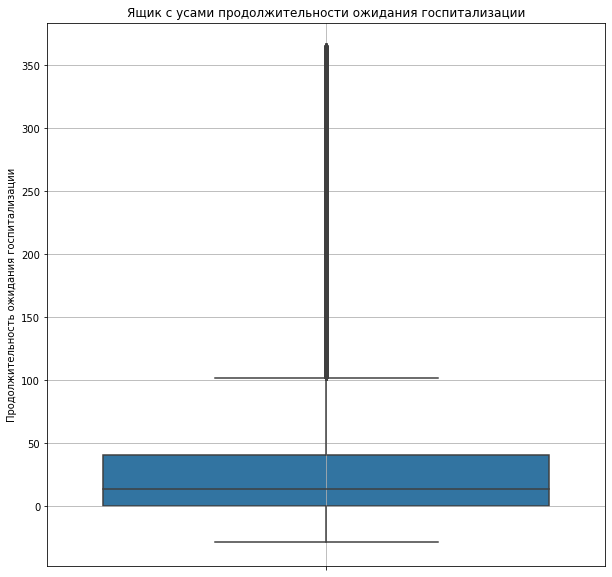

In [30]:
plt.figure(figsize = (10,10) )
sns.boxplot(y = beds["waiting"])
plt.title('Ящик с усами продолжительности ожидания госпитализации')
plt.ylabel('Продолжительность ожидания госпитализации')
plt.grid()
plt.show()

Вывод. Среднее время продолжительности ожидания госпитализации составляет 34 дня

### Количество уникалных пациентов

In [31]:
print('Количество уникальных пациентов, по которым есть записи - ', beds['user_id'].nunique())

Количество уникальных пациентов, по которым есть записи -  45364


### Фактор плановая/экстренная 

In [32]:
beds_plan= beds.pivot_table(index = 'is_plan', values = 'waiting', aggfunc = ['count', 'mean', 'median', 'max'])
beds_plan.columns = ['count', 'mean', 'median', 'max']
beds_plan['mean'] = round(beds_plan['mean'])
beds_plan = beds_plan.reset_index()
beds_plan
# строим таблицу для оценки влияния фактора плановости на время ожидания госпитализации

,is_plan,count,mean,median,max
0,Плановая,86289,35.0,14.0,364.0
1,Экстренная,797,30.0,12.0,362.0


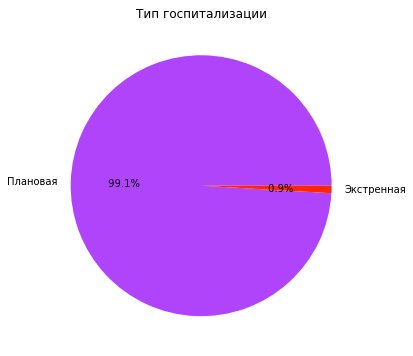

In [33]:
plt.figure(figsize = (12, 6))
labels = ['Плановая', 'Экстренная']
beds_plan ['count'].plot(kind = 'pie', autopct =' %1.1f%%', labels=labels, colors = sns.color_palette('gist_ncar_r'))
plt.title ('Тип госпитализации')
plt.ylabel('')
plt.show()

Вывод. Подавляющее большинство всех госпитализаций является плановыми

### Фактор региона

In [34]:
beds_region = beds.pivot_table(index = 'region', values = 'waiting', aggfunc = ['mean', 'median'])
beds_region.columns = [ 'mean', 'median']
beds_region['mean'] = round(beds_region['mean'])
beds_region
# строим таблицу для оценки влияния фактора региона на продолжительность ожидания госпитализации

,mean,median
region,,
-,0.0,0.0
абхазия,20.0,20.0
алтайский край,29.0,13.0
амурская область,65.0,40.5
архангельская обл.,40.0,21.0
...,...,...
чеченская республика,20.0,0.0
чувашская республика,38.0,16.5
чукотский ао,49.0,34.0


In [35]:
beds_region_user= beds.pivot_table(index = 'region', values = 'user_id', aggfunc = ['count', 'nunique'])
beds_region_user.columns = ['count', 'nunique']
beds_region_user
# строим таблицу для оценки количества пациентов

,count,nunique
region,,
-,1,1
абхазия,1,1
алтайский край,127,64
амурская область,140,65
архангельская обл.,796,400
...,...,...
чеченская республика,794,528
чувашская республика,96,54
чукотский ао,53,29


In [36]:
region_analys = pd.concat([beds_region, beds_region_user], axis = 1, 
                          join = 'inner').sort_values(by = 'count', ascending = False)
region_analys
# объединим таблицы

,mean,median,count,nunique
region,,,,
ленинградская обл.,28.0,12.0,13309,6810
новгородская обл.,38.0,23.0,4376,2140
псковская обл.,43.0,26.0,2926,1359
вологодская обл.,50.0,28.0,2919,1156
республика карелия,45.0,29.0,2375,1239
...,...,...,...,...
бомжи,0.0,0.0,1,1
россия,0.0,0.0,1,1
республика абхазия,9.0,9.0,1,1


In [37]:
region_analys['count'].describe()

count       98.000000
mean       504.183673
std       1477.405411
min          1.000000
25%         62.250000
50%        147.000000
75%        306.750000
max      13309.000000
Name: count, dtype: float64

In [38]:
region_10_percent = round(np.percentile(region_analys['count'], 10))
print('Не более 10% регионов, в которых количество пациентов менее', region_10_percent)
# расчитаем 10% 

Не более 10% регионов, в которых количество пациентов менее 7


In [39]:
region_analys_filter = region_analys.reset_index().query('count >= @region_10_percent')
region_filter = region_analys_filter['region'].unique()
beds = beds.query('region in @region_filter')
# отсечем записи по этим регионам

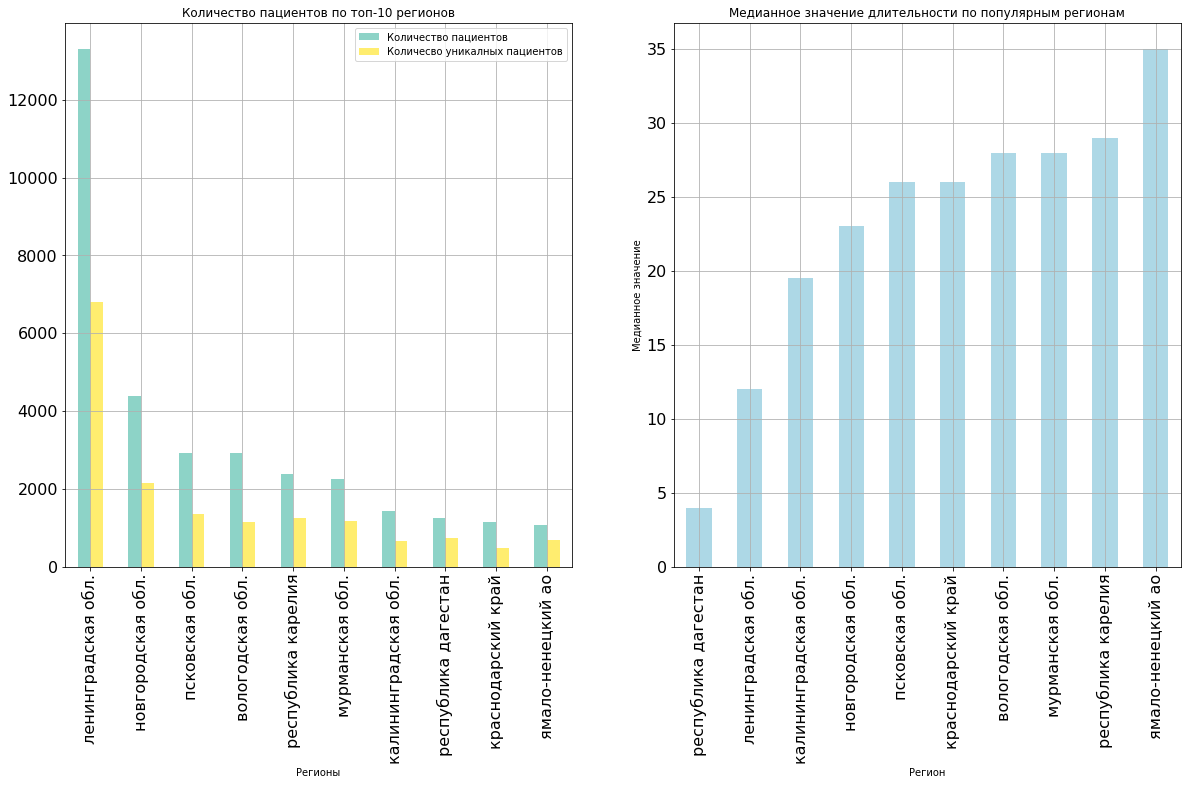

In [40]:
region_analys_top_c = region_analys[['count', 'nunique']].sort_values(by = 'count', ascending = False).head(10)
region_analys_top_m = region_analys[['median', 'count']].sort_values(by = 'count', ascending = False).head(10)

plt.figure(figsize = (20, 10))
region_analys_top_c[['count', 'nunique']].plot(kind = 'bar', ax = plt.subplot(1,2,1), colormap = 'Set3', fontsize=16 )
plt.title('Количество пациентов по топ-10 регионов')
plt.legend(['Количество пациентов', 'Количесво уникалных пациентов'])
plt.grid()
plt.xlabel('Регионы')

region_analys_top_m[[ 'median']].sort_values(by = 'median', ascending = True).plot( kind = 'bar', 
                        figsize = (15, 5), xlabel = 'Регион', ylabel = 'Медианное значение',
                        color = 'lightblue', legend = False, subplots = True, ax=plt.subplot(1,2,2), fontsize=16)
plt.title('Медианное значение длительности по популярным регионам')
plt.grid()
plt.show()
# выводим графики по ТОР-10 регионов

ВЫВОДЫ. Количество пациентов из Ленинградской области сильно превышает количество пациентов из других регионов. 2-6 место по количеству пациентво занимают пациенты из Северо-западного ФО. Медианное значение времени ожидания госпитализации с момента выдачи направдения у пациентов Ленинградской области ниже, чем у пациентов других регионов

### Фактор источника финансирования

In [41]:
beds_fin = beds.pivot_table(index = 'fin_source', values = 'waiting', aggfunc = ['mean', 'median'])
beds_fin.columns = [ 'mean', 'median']
beds_fin['mean'] = round(beds_fin['mean'])
beds_fin
# строим таблицу для оценки влияния фактора источника финансирования на время ожидания

,mean,median
fin_source,,
Бюджет,16.0,17.0
ВМП,31.0,14.0
ДМС,20.0,11.0
Клинические апробации,17.0,0.0
Клинические исследования,0.0,0.0
Наличный расчет,8.0,0.0
ОМС,42.0,21.0


In [42]:
beds_fin_user= beds.pivot_table(index = 'fin_source', values = 'user_id', aggfunc = ['count', 'nunique'])
beds_fin_user.columns = ['count', 'nunique']
beds_fin_user
# строим таблицу для оценки количества пациентов

,count,nunique
fin_source,,
Бюджет,35,35
ВМП,10727,5164
ДМС,72,61
Клинические апробации,650,480
Клинические исследования,12,4
Наличный расчет,119,114
ОМС,37772,22359


In [43]:
fin_source_analys = pd.concat([beds_fin, beds_fin_user], axis = 1, 
                          join = 'inner').sort_values(by = 'count', ascending = False)
fin_source_analys
# объединим таблицы

,mean,median,count,nunique
fin_source,,,,
ОМС,42.0,21.0,37772,22359
ВМП,31.0,14.0,10727,5164
Клинические апробации,17.0,0.0,650,480
Наличный расчет,8.0,0.0,119,114
ДМС,20.0,11.0,72,61
Бюджет,16.0,17.0,35,35
Клинические исследования,0.0,0.0,12,4


In [44]:
fin_source_5_percent = round(np.percentile(fin_source_analys['count'], 5))
print('Не более 5% источников финансирования, в которых количество пациентов менее', fin_source_5_percent)
# расчитаем 5% 

Не более 5% источников финансирования, в которых количество пациентов менее 19


In [45]:
fin_source_analys_filter = fin_source_analys.reset_index().query('count >= @fin_source_5_percent')
fin_source_filter = fin_source_analys_filter['fin_source'].unique()
beds = beds.query('fin_source in @fin_source_filter')
# отсечем записи по этим регионам

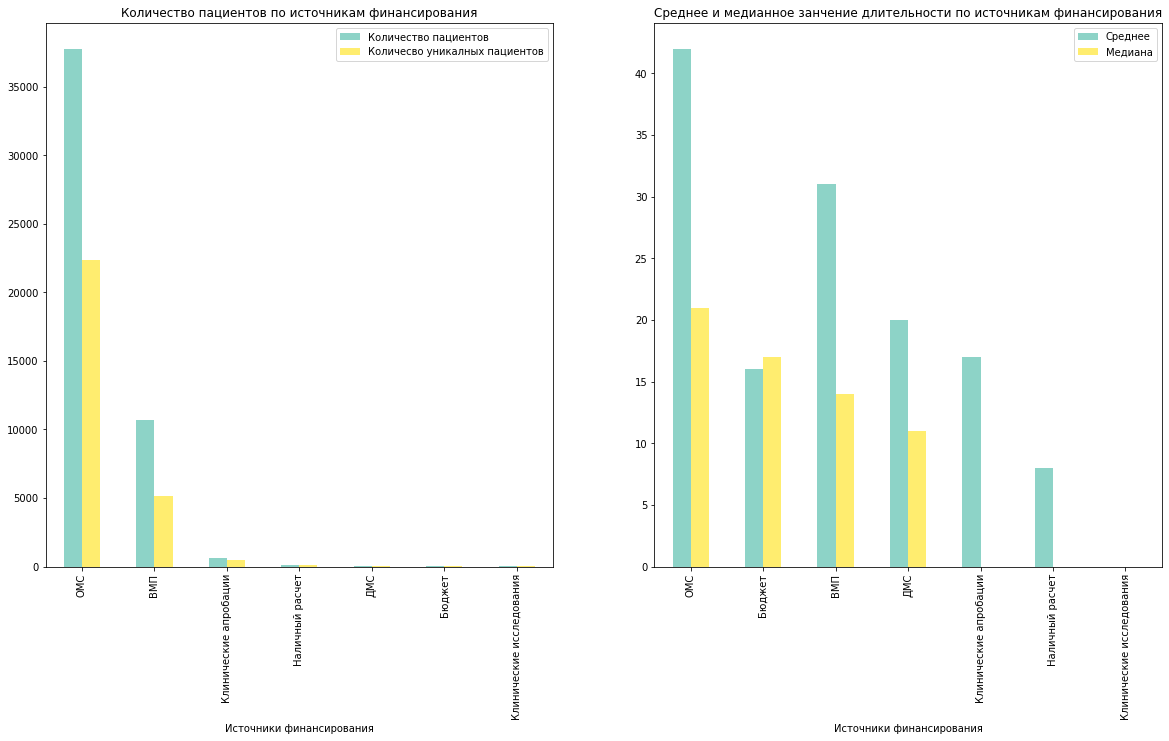

In [46]:
fin_source_analys_top_c = fin_source_analys[['count', 'nunique']].sort_values(by = 'count', ascending = False).head(10)
fin_source_analys_top_m = fin_source_analys[['mean', 'median']].sort_values(by = 'median', ascending = False).head(10)

plt.figure(figsize = (20, 10))
fin_source_analys_top_c[['count', 'nunique']].plot(kind = 'bar', ax = plt.subplot(1,2,1), colormap = 'Set3' )
plt.title('Количество пациентов по источникам финансирования')
plt.legend(['Количество пациентов', 'Количесво уникалных пациентов'])
plt.xlabel('Источники финансирования')

fin_source_analys_top_m[['mean', 'median']].plot(kind = 'bar', ax = plt.subplot(1,2,2), colormap = 'Set3' )
plt.title('Среднее и медианное занчение длительности по источникам финансирования')
plt.legend(['Среднее', 'Медиана'])
plt.xlabel('Источники финансирования')
#plt.xticks(rotation=45)
plt.show()
# выводим графики по источникам финансирования

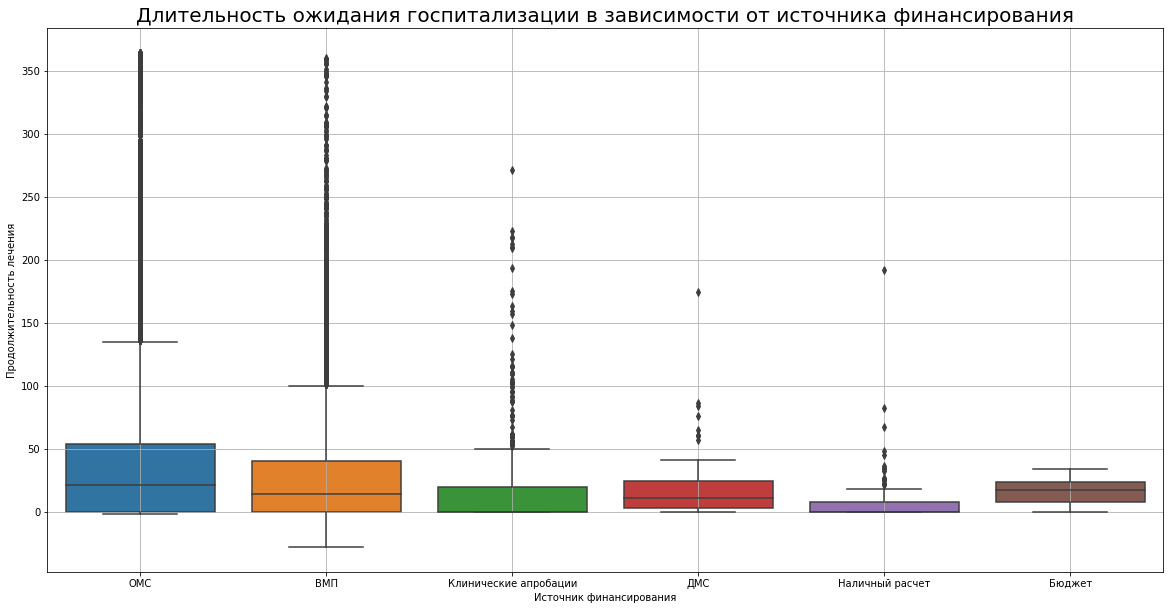

In [47]:
boxplot = plt.subplots(figsize = (20,10))
sns.boxplot(x = 'fin_source', y = 'waiting', data = beds)
plt.title('Длительность ожидания госпитализации в зависимости от источника финансирования', fontsize=20)
plt.xlabel('Источник финансирования')
plt.ylabel('Продолжительность лечения')
plt.grid()
plt.show()
# строим ящик с усами

In [48]:
fin_source_analys_filter.corr()
# проверяем корреляцию

,mean,median,count,nunique
mean,1.000000,0.750111,0.904754,0.887808
median,0.750111,1.000000,0.644272,0.633287
count,0.904754,0.644272,1.000000,0.998439
nunique,0.887808,0.633287,0.998439,1.000000


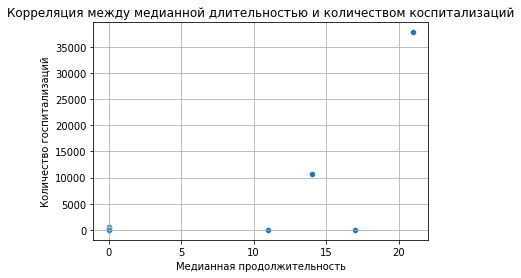

In [49]:
sns.scatterplot(data = fin_source_analys, x = 'median', y = 'count')
plt.title('Корреляция между медианной длительностью и количеством коспитализаций')
plt.xlabel('Медианная продолжительность')
plt.ylabel('Количество госпитализаций')
plt.grid()
plt.show()

Вывод. Большинство госпитализаций проходят по ОМС, но среднее и медианное значения времени ожидания у таких пациентов выше. Необходимо проверить гипотезу о равенстве ожидания госпитализации при ОМС  и иных источниках финансирования

### Фактор плательщика

In [50]:
beds_payer = beds.pivot_table(index = 'payer', values = 'waiting', aggfunc = ['mean', 'median'])
beds_payer.columns = [ 'mean', 'median']
beds_payer['mean'] = round(beds_payer['mean'])
beds_payer.head(5)
# строим таблицу для оценки влияния фактора плательщика на время ожидания госпитализации

,mean,median
payer,,
Альфастрахование,6.0,1.0
"БФ ""Правмир""",57.0,57.0
Высокотехнологичная медицинская помощь,31.0,14.0
Ингосстрах ОСАО,5.0,4.0
Капитал полис,9.0,7.0


In [51]:
beds_payer_user= beds.pivot_table(index = 'payer', values = 'user_id', aggfunc = ['count', 'nunique'])
beds_payer_user.columns = ['count', 'nunique']
beds_payer_user.head(5)
# строим таблицу для оценки количества пациентов по плательщикам

,count,nunique
payer,,
Альфастрахование,5,4
"БФ ""Правмир""",1,1
Высокотехнологичная медицинская помощь,10727,5164
Ингосстрах ОСАО,3,3
Капитал полис,5,2


In [52]:
payer_analys = pd.concat([beds_payer, beds_payer_user], axis = 1, 
                          join = 'inner').sort_values(by = 'count', ascending = False)
payer_analys.head(5)
# объединим таблицы

,mean,median,count,nunique
payer,,,,
ОМС 86 Регион,44.0,24.0,27001,16425
Высокотехнологичная медицинская помощь,31.0,14.0,10727,5164
Фонд-Иногородние,40.0,21.0,9397,7281
Клинические апробации,17.0,0.0,650,480
Терфонд ЛО (не трогать!),23.0,13.0,298,271


In [53]:
payer_40_percent = round(np.percentile(payer_analys['count'], 40))
print('Не более 40% источников финансирования, в которых количество пациентов менее', payer_40_percent)
# расчитаем 40% 

Не более 40% источников финансирования, в которых количество пациентов менее 33


In [54]:
payer_analys_filter = payer_analys.reset_index().query('count >= @payer_40_percent')
payer_filter = payer_analys_filter['payer'].unique()
beds = beds.query('payer in @payer_filter')
# отсечем записи по этим источникам

In [55]:
beds_payer_user= beds.pivot_table(index = 'payer', values = 'user_id', aggfunc = ['count', 'nunique'])
beds_payer_user.columns = ['count', 'nunique']
beds_payer_user = beds_payer_user.sort_values(by = 'count', ascending = False).head(5)

# строим таблицу для оценки количества пациентов по плательщикам

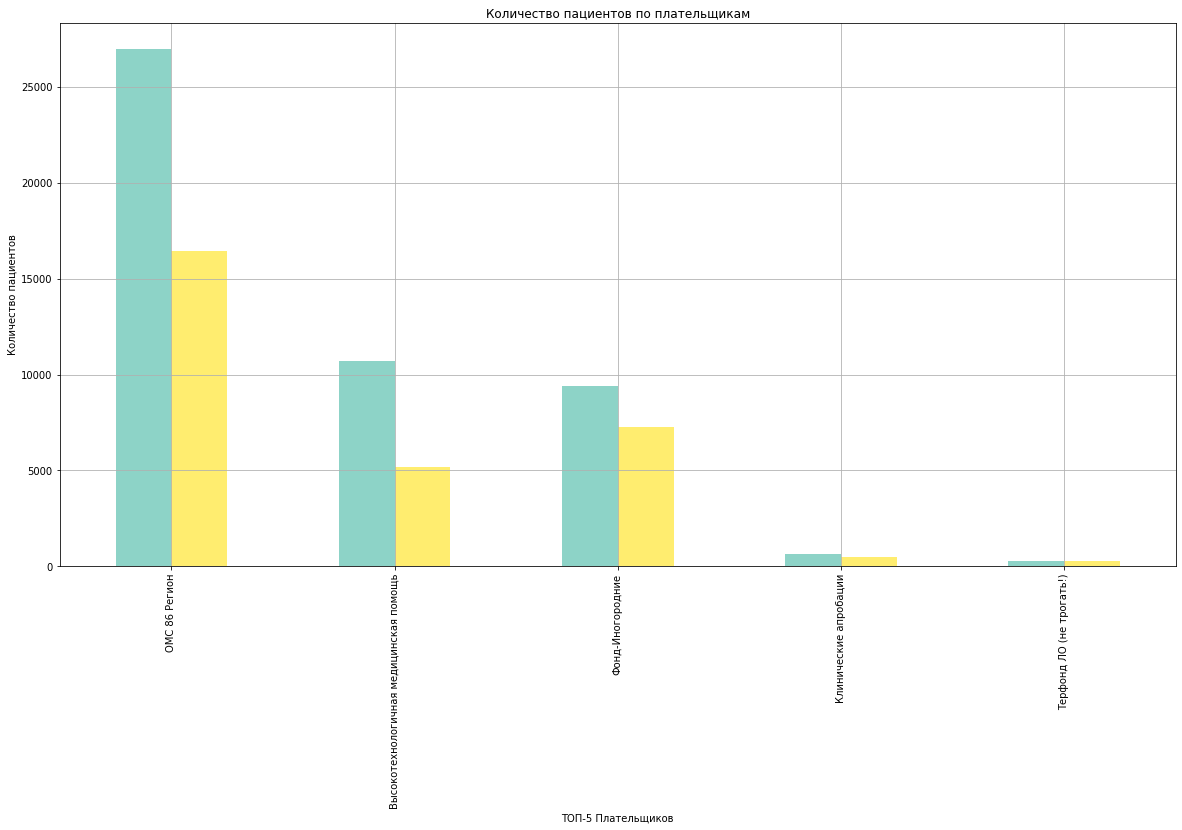

In [56]:
beds_payer_user.plot (y = ['count', 'nunique'], kind = 'bar', figsize = (20, 10), 
                      xlabel = 'ТОП-5 Плательщиков',ylabel = 'Количество пациентов',
                      colormap ='Set3', title = 'Количество пациентов по плательщикам',grid = True, legend = False)
plt.show()

In [57]:
payer_analys.corr()

,mean,median,count,nunique
mean,1.000000,0.818442,0.473694,0.484794
median,0.818442,1.000000,0.247989,0.255167
count,0.473694,0.247989,1.000000,0.993104
nunique,0.484794,0.255167,0.993104,1.000000


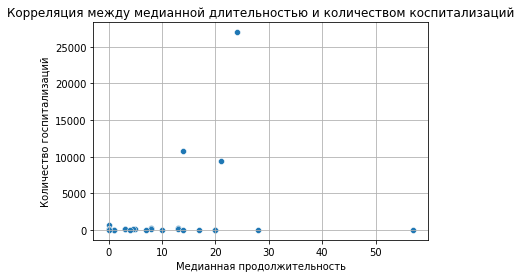

In [58]:
sns.scatterplot(data = payer_analys, x = 'median', y = 'count')
plt.title('Корреляция между медианной длительностью и количеством коспитализаций')
plt.xlabel('Медианная продолжительность')
plt.ylabel('Количество госпитализаций')
plt.grid()
plt.show()

Выводы. Факторы Источник финансирования и Плательщик связаны

### Фактор диагноза

In [59]:
beds_income_mkb = beds.pivot_table(index = 'income_mkb', values = 'waiting', aggfunc = ['mean', 'median'])
beds_income_mkb.columns = [ 'mean', 'median']
beds_income_mkb['mean'] = round(beds_income_mkb['mean'])
beds_income_mkb.head(5)
# строим таблицу для оценки влияния фактора диагноза при поступлении на время ожидания

,mean,median
income_mkb,,
A04.9,61.0,6.0
A09.0,0.0,0.0
A09.9,0.0,0.0
A46,184.0,184.0
A49.3,0.0,0.0


In [60]:
beds_income_mkb_user= beds.pivot_table(index = 'income_mkb', values = 'user_id', aggfunc = ['count', 'nunique'])
beds_income_mkb_user.columns = ['count', 'nunique']
beds_income_mkb_user.head(5)
# строим таблицу для оценки количества пациентов по диагнозам

,count,nunique
income_mkb,,
A04.9,5,5
A09.0,1,1
A09.9,1,1
A46,1,1
A49.3,1,1


In [61]:
income_mkb_analys = pd.concat([beds_income_mkb, beds_income_mkb_user], axis = 1, 
                          join = 'inner').sort_values(by = 'nunique', ascending = False)
income_mkb_analys.head(5)
# объединим таблицы

,mean,median,count,nunique
income_mkb,,,,
M08.0,30.0,25.0,3775,1401
L20.8,34.0,14.0,1714,694
J35.2,42.0,28.0,677,656
N13.7,45.0,1.0,1141,609
E10.9,21.0,15.5,770,585


In [62]:
print ('Коэффициент кореляции между кол-вом пациентов ии средней длительностью ожидания',
       income_mkb_analys['count'].corr(income_mkb_analys['mean']))

Коэффициент кореляции между кол-вом пациентов ии средней длительностью ожидания 0.053667126016069704


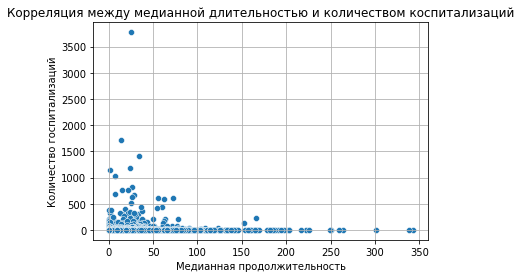

In [63]:
sns.scatterplot(data = income_mkb_analys, x = 'median', y = 'count')
plt.title('Корреляция между медианной длительностью и количеством коспитализаций')
plt.xlabel('Медианная продолжительность')
plt.ylabel('Количество госпитализаций')
plt.grid()
plt.show()

In [64]:
income_mkb_analys_filter = income_mkb_analys.reset_index().query('nunique >= 100')
income_mkb_filter = income_mkb_analys_filter['income_mkb'].unique()
beds = beds.query('income_mkb in @income_mkb_filter')
# отсечем записи по диагнозам менее 100

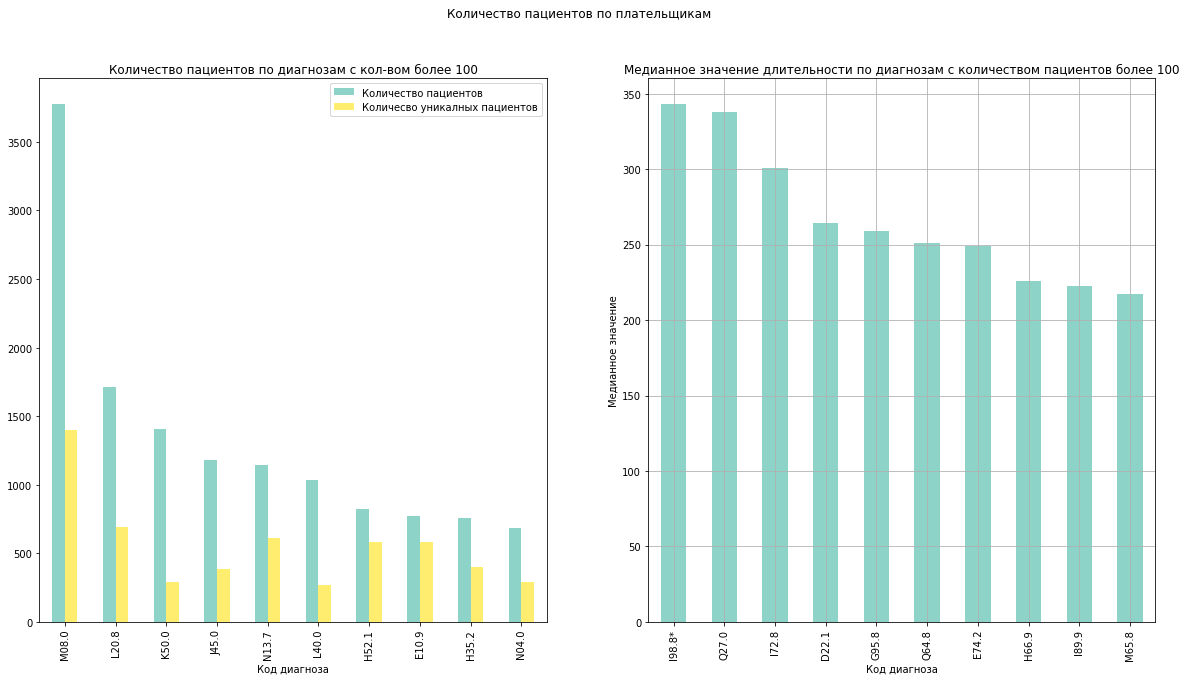

In [65]:
income_mkb_analys_filter_c = income_mkb_analys[['count', 'nunique']].sort_values(by = 'count', ascending = False).head(10)
income_mkb_analys_filter_m = income_mkb_analys[['median', 'count']].sort_values(by = 'median', ascending = False).head(10)

plt.figure(figsize = (20, 10))
income_mkb_analys_filter_c[['count', 'nunique']].plot(kind = 'bar', ax = plt.subplot(1,2,1), colormap = 'Set3' )
plt.title('Количество пациентов по диагнозам с кол-вом более 100')
plt.legend(['Количество пациентов', 'Количесво уникалных пациентов'])
plt.xlabel('Код диагноза')


income_mkb_analys_filter_m.plot(y = 'median', kind = 'bar', figsize = (20, 10), ax = plt.subplot(1,2,2), subplots = True,
                      xlabel = 'Код диагноза',ylabel = 'Медианное значение',colormap ='Set3',
                      title = 'Количество пациентов по плательщикам',grid = True, legend = False)
plt.title('Медианное значение длительности по диагнозам с количеством пациентов более 100')                      
plt.show()
# выводим графики по диагнозам с количеством более 100 пациентов

Вывод

### Фактор отделения

In [66]:
beds_dept = beds.pivot_table(index = 'dept', values = 'waiting', aggfunc = ['mean', 'median'])
beds_dept.columns = [ 'mean', 'median']
beds_dept['mean'] = round(beds_dept['mean'])
beds_dept.head(5)
# строим таблицу для оценки влияния фактора Отделения на ожидание

,mean,median
dept,,
Гастроэнтерологическое отделение,56.0,39.0
Гинекологическое отделение перинатального центра,3.0,0.0
Дневной стационар Гастроэнтерологического отделения,40.0,24.0
Дневной стационар Кожно-венерологического отделения,30.0,0.0
Дневной стационар ПО1,28.0,19.5


In [67]:
beds_dept_user= beds.pivot_table(index = 'dept', values = 'user_id', aggfunc = ['count', 'nunique'])
beds_dept_user.columns = ['count', 'nunique']
beds_dept_user.head(5)
# строим таблицу для оценки количества пациентов по отделениям

,count,nunique
dept,,
Гастроэнтерологическое отделение,2680,848
Гинекологическое отделение перинатального центра,540,530
Дневной стационар Гастроэнтерологического отделения,55,53
Дневной стационар Кожно-венерологического отделения,21,21
Дневной стационар ПО1,24,24


In [68]:
dept_analys = pd.concat([beds_dept, beds_dept_user], axis = 1, 
                          join = 'inner').sort_values(by = 'median', ascending = False)
dept_analys
# объединим таблицы

,mean,median,count,nunique
dept,,,,
Психоневрологическое отд.,63.0,48.0,2756,1954
Микрохирургическое отделение,87.0,47.0,665,424
Гастроэнтерологическое отделение,56.0,39.0,2680,848
ПЭМП ДПО,51.0,35.5,28,28
Хирургическое отделение №3,67.0,35.0,807,506
Дневной стационар эндокринологического отд.,37.0,31.5,6,6
Инфекционно-диагностическое,50.0,29.0,241,238
ПЦ Отделение вспомогательных репродуктивных технологий ДС,45.0,28.0,301,204
Отоларингологическое отделение,47.0,27.0,1630,1315


In [69]:
dept_analys.corr()

,mean,median,count,nunique
mean,1.000000,0.820060,0.283123,0.308541
median,0.820060,1.000000,0.290907,0.285206
count,0.283123,0.290907,1.000000,0.922015
nunique,0.308541,0.285206,0.922015,1.000000


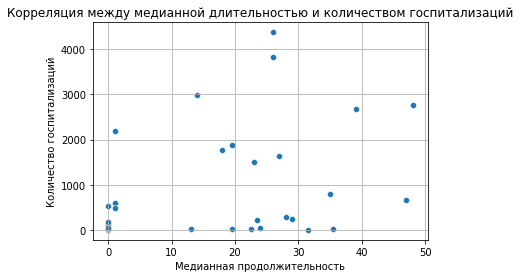

In [70]:
sns.scatterplot(data = dept_analys, x = 'median', y = 'count')
plt.title('Корреляция между медианной длительностью и количеством госпитализаций')
plt.xlabel('Медианная продолжительность')
plt.ylabel('Количество госпитализаций')
plt.grid()
plt.show()

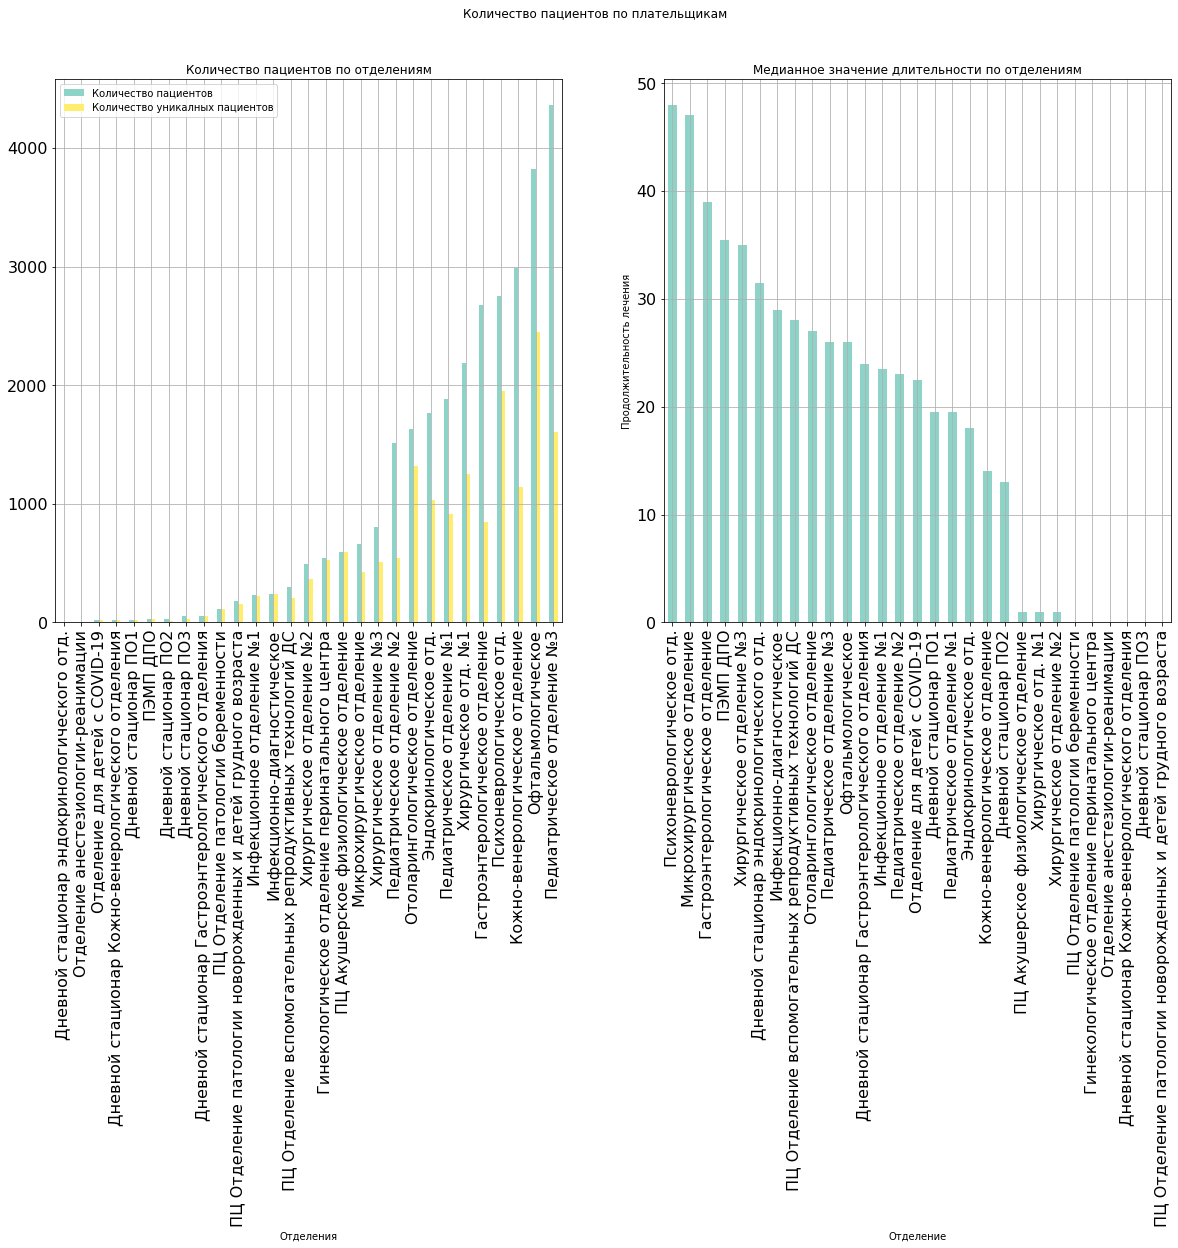

In [71]:
#income_mkb_analys_filter_c = income_mkb_analys[['count', 'nunique']].sort_values(by = 'count', ascending = False).head(10)
#income_mkb_analys_filter_m = income_mkb_analys[['median', 'count']].sort_values(by = 'median', ascending = False)


plt.figure(figsize = (20, 10))
dept_analys[['count', 'nunique']].sort_values(by = "count").\
plot(kind = 'bar',fontsize=16, ax = plt.subplot(1,2,1), colormap = 'Set3',grid=True )
plt.title('Количество пациентов по отделениям')
plt.legend(['Количество пациентов', 'Количество уникалных пациентов'])
plt.xlabel('Отделения')


dept_analys.plot(y = 'median', kind = 'bar', figsize = (20, 10), ax = plt.subplot(1,2,2), subplots = True,
                      xlabel = 'Отделение',ylabel = 'Продолжительность лечения',colormap ='Set3',
                      title = 'Количество пациентов по плательщикам',grid = True, legend = False, fontsize=16)
plt.title('Медианное значение длительности по отделениям')                      
plt.show()
# выводим графики по диагнозам с количеством более 100

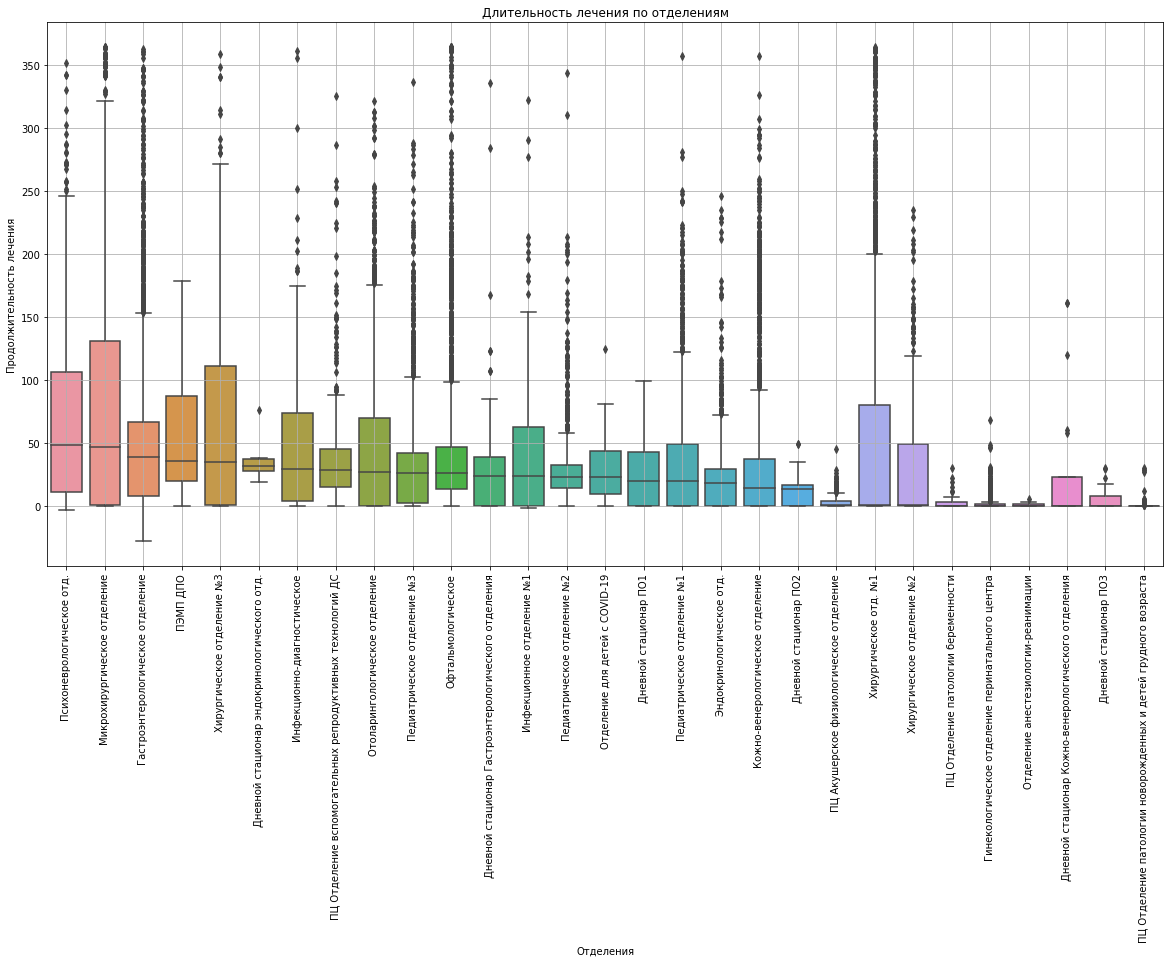

In [72]:
plt.figure(figsize=(20, 10))
sns.boxplot(data = beds, x = 'dept',  y = 'waiting',\
            order = beds.groupby('dept')['waiting'].agg('median').sort_values(ascending=False).index)
plt.title('Длительность лечения по отделениям')
plt.xlabel('Отделения')
plt.ylabel('Продолжительность лечения')
plt.xticks(rotation = 90)
plt.grid()
plt.show()
# строим ящик с усами

Вывод. Слабая зависимость между кол-вом уникальных пациентов и медианным значением длительности ожидания.

### Фактор профиль отделения

In [73]:
beds_profile = beds.pivot_table(index = 'profile', values = 'waiting', aggfunc = ['mean', 'median'])
beds_profile.columns = [ 'mean', 'median']
beds_profile['mean'] = round(beds_profile['mean'])
beds_profile.head(5)
# строим таблицу для оценки влияния фактора профиля Отделения

,mean,median
profile,,
Аллергологические ДС,13.0,13.0
Аллергология,26.0,23.0
Венерологические,7.0,5.5
Гастроэнтерологические,56.0,39.0
Гастроэнтерологические ДС,40.0,24.0


In [74]:
beds_profile_user= beds.pivot_table(index = 'dept', values = 'user_id', aggfunc = ['count', 'nunique'])
beds_profile_user.columns = ['count', 'nunique']
beds_profile_user.head(5)
# строим таблицу для оценки количества пациентов по профилю отделения

,count,nunique
dept,,
Гастроэнтерологическое отделение,2680,848
Гинекологическое отделение перинатального центра,540,530
Дневной стационар Гастроэнтерологического отделения,55,53
Дневной стационар Кожно-венерологического отделения,21,21
Дневной стационар ПО1,24,24


In [75]:
profile_analys = pd.concat([beds_dept, beds_dept_user], axis = 1, 
                          join = 'inner').sort_values(by = 'median', ascending = False)
profile_analys
# объединим таблицы

,mean,median,count,nunique
dept,,,,
Психоневрологическое отд.,63.0,48.0,2756,1954
Микрохирургическое отделение,87.0,47.0,665,424
Гастроэнтерологическое отделение,56.0,39.0,2680,848
ПЭМП ДПО,51.0,35.5,28,28
Хирургическое отделение №3,67.0,35.0,807,506
Дневной стационар эндокринологического отд.,37.0,31.5,6,6
Инфекционно-диагностическое,50.0,29.0,241,238
ПЦ Отделение вспомогательных репродуктивных технологий ДС,45.0,28.0,301,204
Отоларингологическое отделение,47.0,27.0,1630,1315


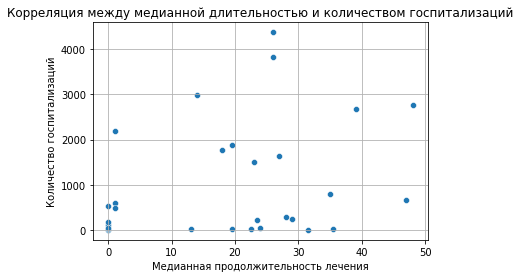

In [76]:
sns.scatterplot(data = profile_analys, x = 'median', y = 'count')
plt.title('Корреляция между медианной длительностью и количеством госпитализаций')
plt.xlabel('Медианная продолжительность лечения')
plt.ylabel('Количество госпитализаций')
plt.grid()
plt.show()

In [77]:
profile_analys.corr()

,mean,median,count,nunique
mean,1.000000,0.820060,0.283123,0.308541
median,0.820060,1.000000,0.290907,0.285206
count,0.283123,0.290907,1.000000,0.922015
nunique,0.308541,0.285206,0.922015,1.000000


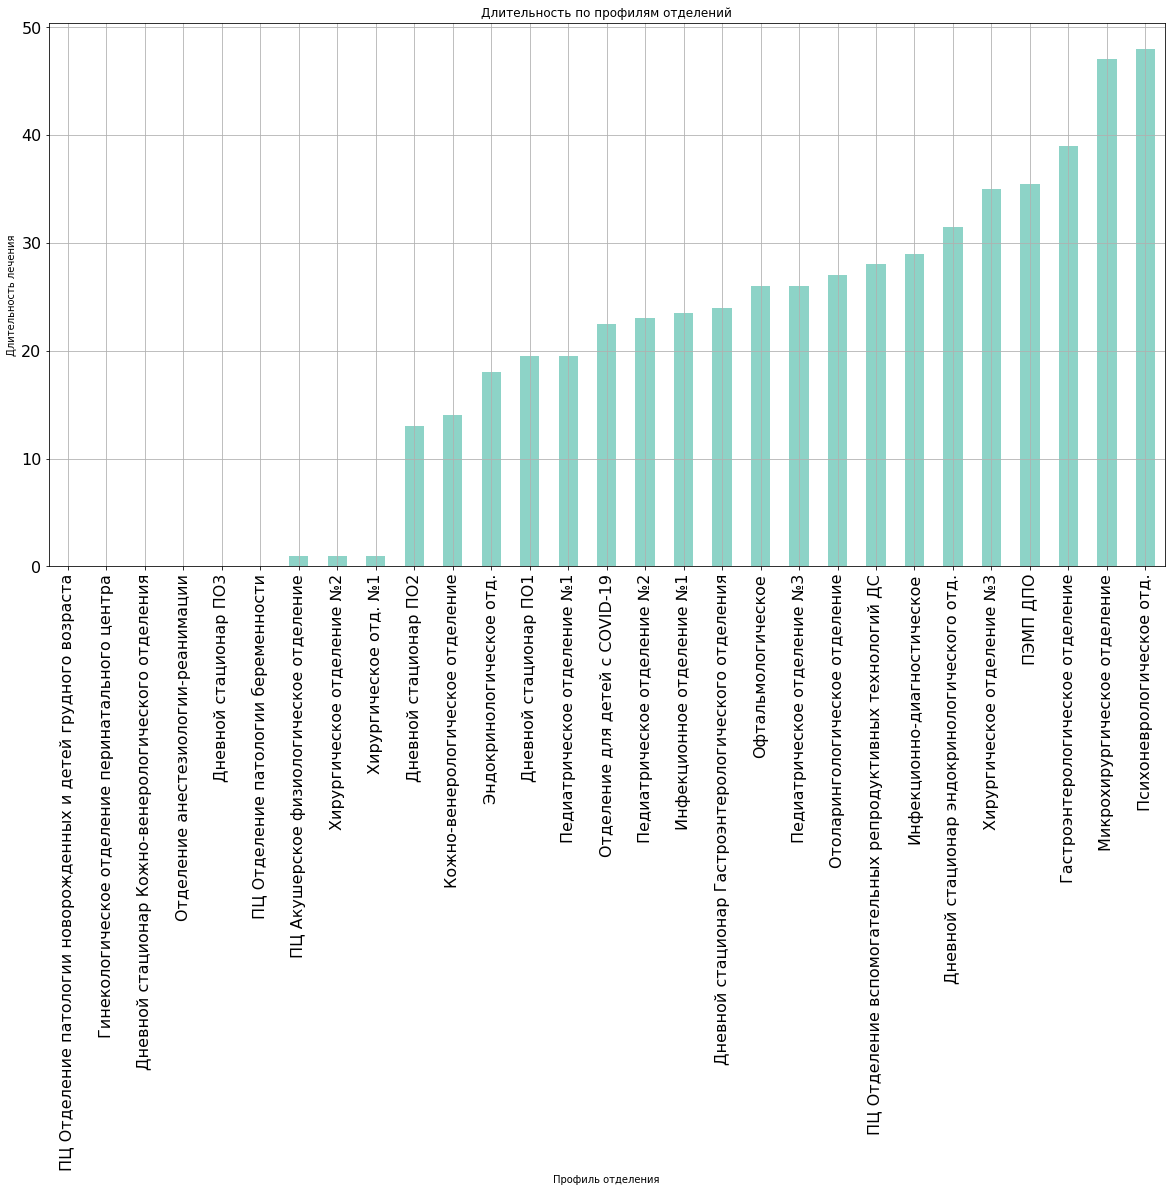

In [78]:
profile_analys.groupby('dept')['median'].sum().sort_values()\
.plot(kind = 'bar', y = 'count', grid = True,  figsize = (20,10), colormap ='Set3', fontsize=16)
plt.title ('Длительность по профилям отделений')
plt.xticks(rotation=90)
plt.xlabel('Профиль отделения')
plt.ylabel('Длительность лечения')
plt.show()

Вывод. Факторы Профиль отделения и Отделение связаны. Дольше всего ожидают лечения пациенты психоневрологического отделения и микрохирургического отделения. Пациенты с заболеваниями, требующими немедленного вмешательства ожидают меньше всего. Это гинекологическое, акушерское и хирургические отделения.

### Фактор месяца выдачи направления

In [79]:
beds['referral_year'] = beds['referral_date'].dt.year
beds['referral_month'] = beds['referral_date'].dt.month
beds['referral_day'] = beds['referral_date'].dt.day
beds.head(3)
# добавляем столбцы года, месяца, дня поступления

,index,referral_date,income_date,outcome_date,user_id,is_num,code,region,payer,fin_source,dept,profile,bed_days,is_plan,income_mkb,outcome_mkb,waiting,referral_year,referral_month,referral_day
309,307,2018-10-26,2019-01-08,2019-01-18,248527000.0,277,6.1.0,вологодская обл.,Высокотехнологичная медицинская помощь,ВМП,Отоларингологическое отделение,Отоларингологические,11.0,Плановая,J38.6,J38.6,74.0,2018,10,26
322,320,2018-12-19,2019-01-08,2019-01-14,991687000.0,288,5.1.1,ленинградская обл.,"Страховая компания ""РОСНО""",ОМС,Отоларингологическое отделение,Отоларингологические,6.0,Плановая,J35.2,J35.2,20.0,2018,12,19
366,362,2019-01-09,2019-01-09,2019-01-11,993353000.0,335,5.99.0,республика карелия,Фонд-Иногородние,ОМС,Отоларингологическое отделение,Отоларингологические,3.0,Плановая,J35.2,J35.2,0.0,2019,1,9


In [80]:
beds_referral_month = beds.pivot_table(index = 'referral_month', values = 'waiting', aggfunc = ['mean', 'median'])
beds_referral_month.columns = [ 'mean', 'median']
beds_referral_month['mean'] = round(beds_referral_month['mean'])
beds_referral_month
# строим таблицу для оценки влияния фактора месяца направления

,mean,median
referral_month,,
1,32.0,17.0
2,44.0,21.0
3,42.0,22.0
4,49.0,31.0
5,45.0,27.0
6,44.0,25.0
7,46.0,27.0
8,36.0,22.0
9,35.0,21.0


In [81]:
beds_referral_month_user= beds.pivot_table(index = 'referral_month', values = 'user_id', aggfunc = ['count', 'nunique'])
beds_referral_month_user.columns = ['count', 'nunique']
beds_referral_month_user
# строим таблицу для оценки количества пациентов по месяцам направления

,count,nunique
referral_month,,
1,2137,1880
2,2553,2202
3,2782,2335
4,2728,2310
5,2566,2165
6,2617,2184
7,2413,2016
8,1960,1634
9,2672,2251


In [82]:
referral_month_analys = pd.concat([beds_referral_month, beds_referral_month_user], axis = 1, join = 'inner')
referral_month_analys
# объединим таблицы

,mean,median,count,nunique
referral_month,,,,
1,32.0,17.0,2137,1880
2,44.0,21.0,2553,2202
3,42.0,22.0,2782,2335
4,49.0,31.0,2728,2310
5,45.0,27.0,2566,2165
6,44.0,25.0,2617,2184
7,46.0,27.0,2413,2016
8,36.0,22.0,1960,1634
9,35.0,21.0,2672,2251


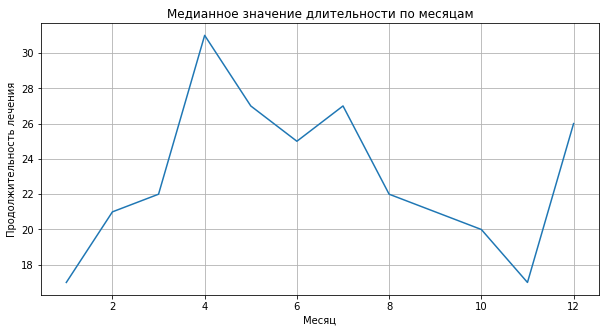

In [83]:
referral_month_analys.plot(y = 'median', kind = 'line', figsize = (10,5),xlabel = 'Месяц', 
                     ylabel = 'Продолжительность лечения',grid = True, legend = False)                     
plt.title('Медианное значение длительности по месяцам')  
plt.show()

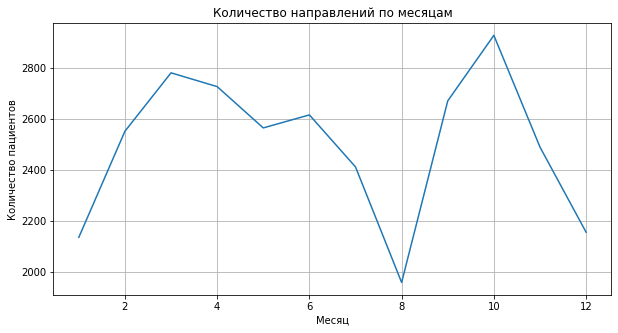

In [84]:
referral_month_analys.plot(y = 'count', kind = 'line', figsize = (10,5),xlabel = 'Месяц', 
                     ylabel = 'Количество пациентов',grid = True, legend = False)                     
plt.title('Количество направлений по месяцам')  
plt.show()

In [85]:
beds_filtered = beds.query('referral_year>2018')
referral = beds_filtered.pivot_table(index = 'referral_month', columns ='referral_year', values = 'waiting',
                                     aggfunc = 'median')
referral 
# таблица по годам

referral_year,2019,2020,2021,2022,2023
referral_month,,,,,
1,20.0,14.0,13.0,27.0,19.0
2,27.5,13.0,20.0,21.0,34.0
3,20.5,1.0,33.0,21.0,23.0
4,21.0,27.0,30.0,31.0,37.0
5,20.0,27.0,26.5,30.0,27.0
6,31.0,15.0,28.0,27.0,22.0
7,49.0,20.0,21.0,29.0,36.0
8,18.5,18.0,22.5,28.0,19.0
9,19.0,18.0,21.0,27.0,21.0


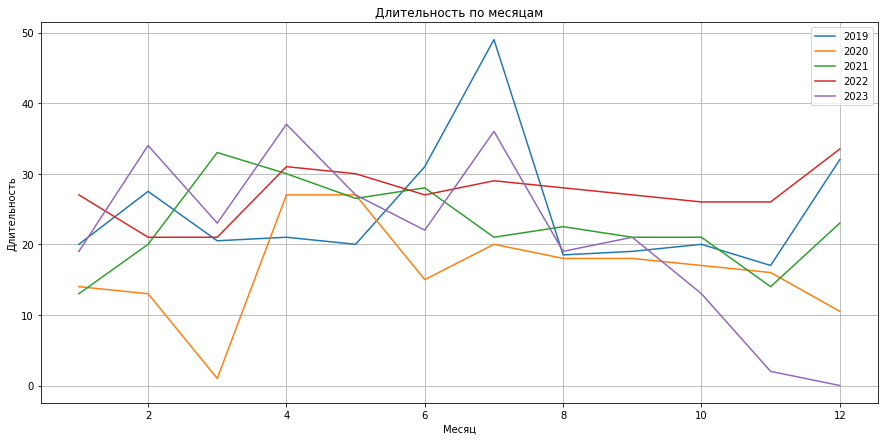

In [86]:
referral.plot(figsize = (15,7), grid = True)
plt.title('Длительность по месяцам')
plt.xlabel('Месяц')
plt.ylabel('Длительность')
plt.legend()
plt.show()

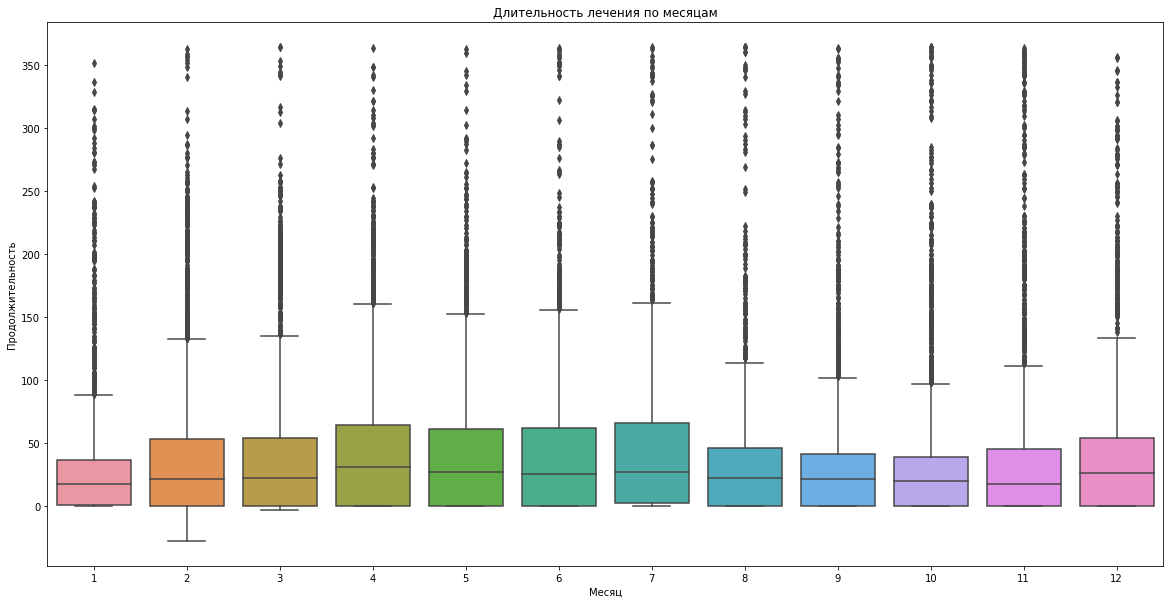

In [87]:
boxplot = plt.subplots(figsize = (20,10))
sns.boxplot(x = 'referral_month', y = 'waiting', data = beds)
plt.title('Длительность лечения по месяцам')
plt.xlabel('Месяц')
plt.ylabel('Продолжительность')
plt.show()
# строим ящик с усами

Вывод. Пик длительности ожидания наблюдается по направлениям, выданным в апреле, после идет на спад до декабря и резко возрастает в декабре. Количество выданых направлений резко возрастает в августе и растет до декабря

### Фактор месяца госпитализации

In [88]:
beds['income_month'] = beds['income_date'].dt.month
beds['income_year'] = beds['income_date'].dt.year
beds.head(2)
# добавляем столбцы месяца и года госпитализации, проверям

,index,referral_date,income_date,outcome_date,user_id,is_num,code,region,payer,fin_source,...,bed_days,is_plan,income_mkb,outcome_mkb,waiting,referral_year,referral_month,referral_day,income_month,income_year
309,307,2018-10-26,2019-01-08,2019-01-18,248527000.0,277,6.1.0,вологодская обл.,Высокотехнологичная медицинская помощь,ВМП,...,11.0,Плановая,J38.6,J38.6,74.0,2018,10,26,1,2019
322,320,2018-12-19,2019-01-08,2019-01-14,991687000.0,288,5.1.1,ленинградская обл.,"Страховая компания ""РОСНО""",ОМС,...,6.0,Плановая,J35.2,J35.2,20.0,2018,12,19,1,2019


In [89]:
beds_income_month = beds.pivot_table(index = 'income_month', values = 'waiting', aggfunc = ['mean', 'median'])
beds_income_month.columns = [ 'mean', 'median']
beds_income_month['mean'] = round(beds_income_month['mean'])
beds_income_month
# строим таблицу для оценки влияния фактора месяца госпитализации

,mean,median
income_month,,
1,39.0,21.0
2,33.0,17.0
3,35.0,20.0
4,32.0,19.0
5,38.0,26.0
6,44.0,26.0
7,39.0,24.0
8,47.0,28.0
9,53.0,27.0


In [90]:
beds_income_month_user= beds.pivot_table(index = 'income_month', values = 'user_id', aggfunc = ['count', 'nunique'])
beds_income_month_user.columns = ['count', 'nunique']
beds_income_month_user
# строим таблицу для оценки количества пациентов по месяцам поступления

,count,nunique
income_month,,
1,2023,1756
2,2353,2000
3,2676,2200
4,2203,1862
5,2293,1927
6,2736,2231
7,2246,1798
8,2363,1870
9,2787,2325


In [91]:
income_month_analys = pd.concat([beds_income_month, beds_income_month_user], axis = 1, join = 'inner')
income_month_analys
# объединим таблицы

,mean,median,count,nunique
income_month,,,,
1,39.0,21.0,2023,1756
2,33.0,17.0,2353,2000
3,35.0,20.0,2676,2200
4,32.0,19.0,2203,1862
5,38.0,26.0,2293,1927
6,44.0,26.0,2736,2231
7,39.0,24.0,2246,1798
8,47.0,28.0,2363,1870
9,53.0,27.0,2787,2325


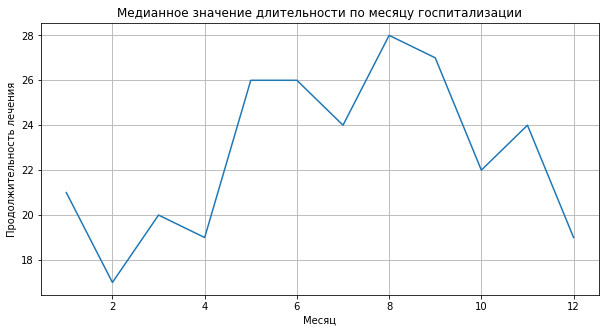

In [92]:
income_month_analys.plot(y = 'median', kind = 'line', figsize = (10,5),xlabel = 'Месяц', 
                     ylabel = 'Продолжительность лечения',grid = True, legend = False)                     
plt.title('Медианное значение длительности по месяцу госпитализации')  
plt.show()

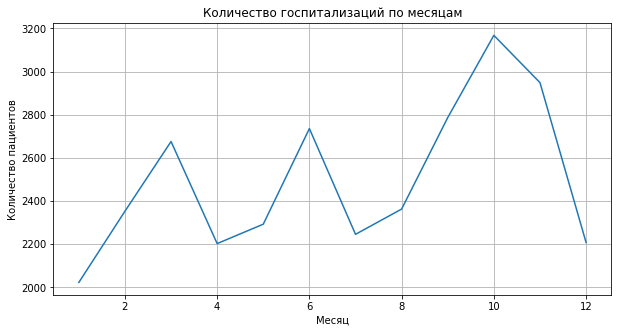

In [93]:
income_month_analys.plot(y = 'count', kind = 'line', figsize = (10,5),xlabel = 'Месяц', 
                     ylabel = 'Количество пациентов',grid = True, legend = False)                     
plt.title('Количество госпитализаций по месяцам')  
plt.show()

In [94]:
income_years = beds.pivot_table(index = 'income_month', columns ='income_year', values = 'waiting',
                                     aggfunc = 'median')
income_years
# таблица по годам

income_year,2019,2020,2021,2022,2023
income_month,,,,,
1,29.0,28.0,7.0,30.5,30.0
2,20.5,19.0,14.0,17.0,18.0
3,21.0,20.0,14.0,19.0,23.0
4,19.0,0.0,15.0,19.0,23.0
5,24.0,19.0,29.0,22.0,25.0
6,20.0,13.0,34.0,27.0,28.0
7,14.0,14.0,23.0,29.0,35.0
8,49.0,21.5,25.0,32.0,32.0
9,26.0,18.0,23.5,32.0,37.0


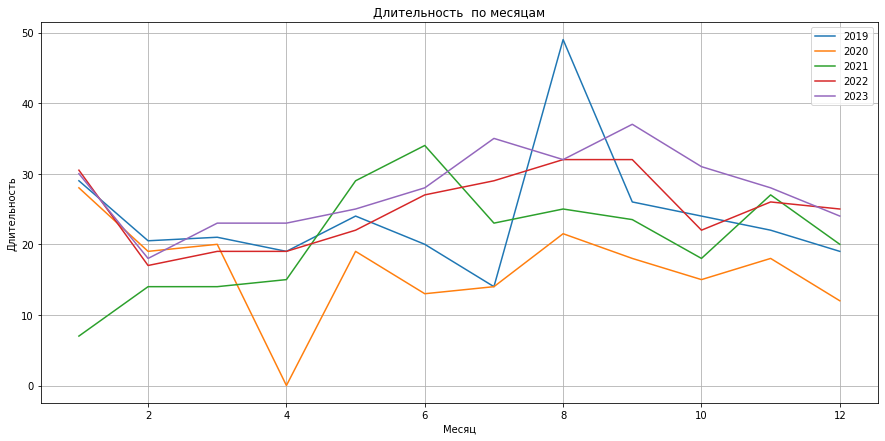

In [95]:
income_years.plot(figsize = (15,7), grid = True)
plt.title('Длительность  по месяцам')
plt.xlabel('Месяц')
plt.ylabel('Длительность')
plt.legend()
plt.show()

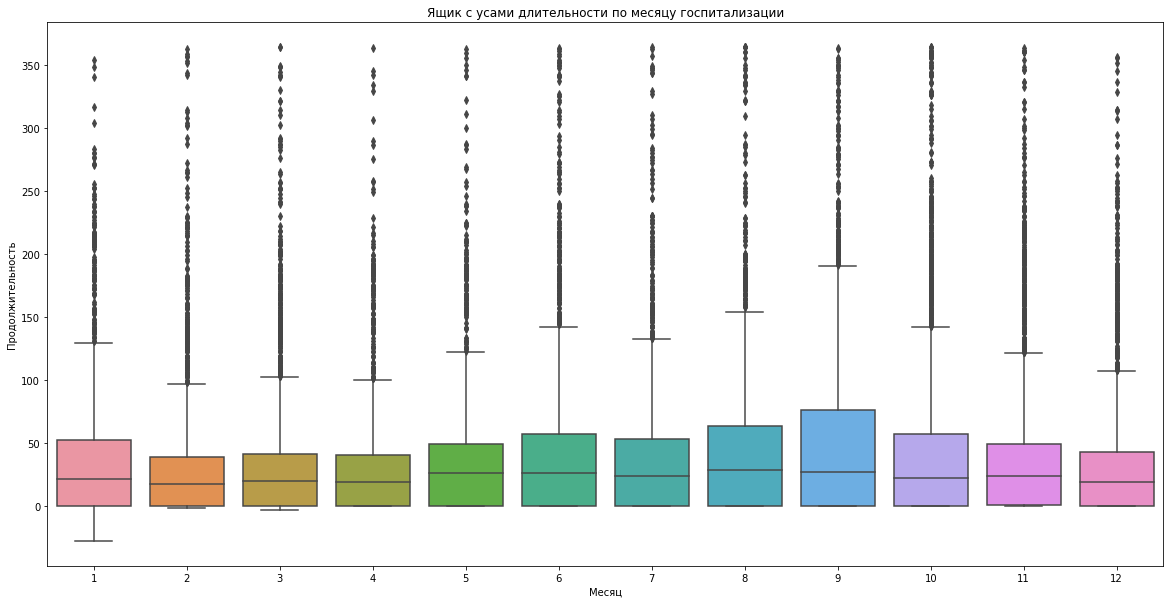

In [96]:
boxplot = plt.subplots(figsize = (20,10))
sns.boxplot(x = 'income_month', y = 'waiting', data = beds)
plt.title('Ящик с усами длительности по месяцу госпитализации')
plt.xlabel('Месяц')
plt.ylabel('Продолжительность')
plt.show()
# строим ящик с усами

Вывод. Больше всего госпитализаций в октябре-ноябре, меньше всего в декабре и январе и апреле

### Анализ данных при напралении позднее или в день госпитализации 

#### Направление позднее госпитализации

In [97]:
beds_minus = beds.query('waiting < 0')
# записи, где дата направления  позднее даты госпитализации
beds_zero = beds.query('waiting == 0')
# записи, где дата направления  в день госпитализации

In [98]:
beds_minus['waiting'].describe()
# смотрим информацию

count     5.000000
mean     -7.000000
std      11.768602
min     -28.000000
25%      -3.000000
50%      -2.000000
75%      -1.000000
max      -1.000000
Name: waiting, dtype: float64

In [99]:
beds_minus_region_user= beds_minus.pivot_table(index = 'region', values = 'user_id', aggfunc = ['count', 'nunique'])
beds_minus_region_user.columns = ['count', 'nunique']
beds_minus_region_user
# строим таблицу для оценки количества пациентов по регионам

,count,nunique
region,,
архангельская обл.,1,1
псковская обл.,1,1
республика дагестан,1,1
республика коми,2,2


In [100]:
beds_minus_fin_user= beds_minus.pivot_table(index = 'fin_source', values = 'user_id', aggfunc = ['count', 'nunique'])
beds_minus_fin_user.columns = ['count', 'nunique']
beds_minus_fin_user
# строим таблицу для оценки количества пациентов по источнику финансирования

,count,nunique
fin_source,,
ВМП,4,4
ОМС,1,1


In [101]:
beds_minus_is_plan= beds_minus.pivot_table(index = 'is_plan', values = 'user_id', aggfunc = ['count', 'nunique'])
beds_minus_is_plan.columns = ['count', 'nunique']
beds_minus_is_plan
# строим таблицу для оценки количества пациентов по типу госпитализации

,count,nunique
is_plan,,
Плановая,5,5


Вывод. Случаев, когда направление было выдано после госпитализации 5 случаев. Срок от 1 до 28 дней. Это регионы Архангельская обл., Коми, Дагестан, Псковская обл. Все случаи плановой госпитализации

#### Направление в день госпитализации

In [102]:
beds_zero['waiting'].describe()
# смотрим информацию

count    8147.0
mean        0.0
std         0.0
min         0.0
25%         0.0
50%         0.0
75%         0.0
max         0.0
Name: waiting, dtype: float64

In [103]:
beds_zero_region_user= beds_zero.pivot_table(index = 'region', values = 'user_id', aggfunc = ['count', 'nunique'])
beds_zero_region_user.columns = ['count', 'nunique']
beds_zero_region_user.sort_values(by = 'count', ascending = False).head(10)
# строим таблицу для оценки количества пациентов по регионам

,count,nunique
region,,
ленинградская обл.,2740,1833
новгородская обл.,648,415
псковская обл.,416,287
вологодская обл.,371,229
республика дагестан,343,249
мурманская обл.,270,193
республика карелия,226,165
краснодарский край,218,146
калининградская обл.,212,148


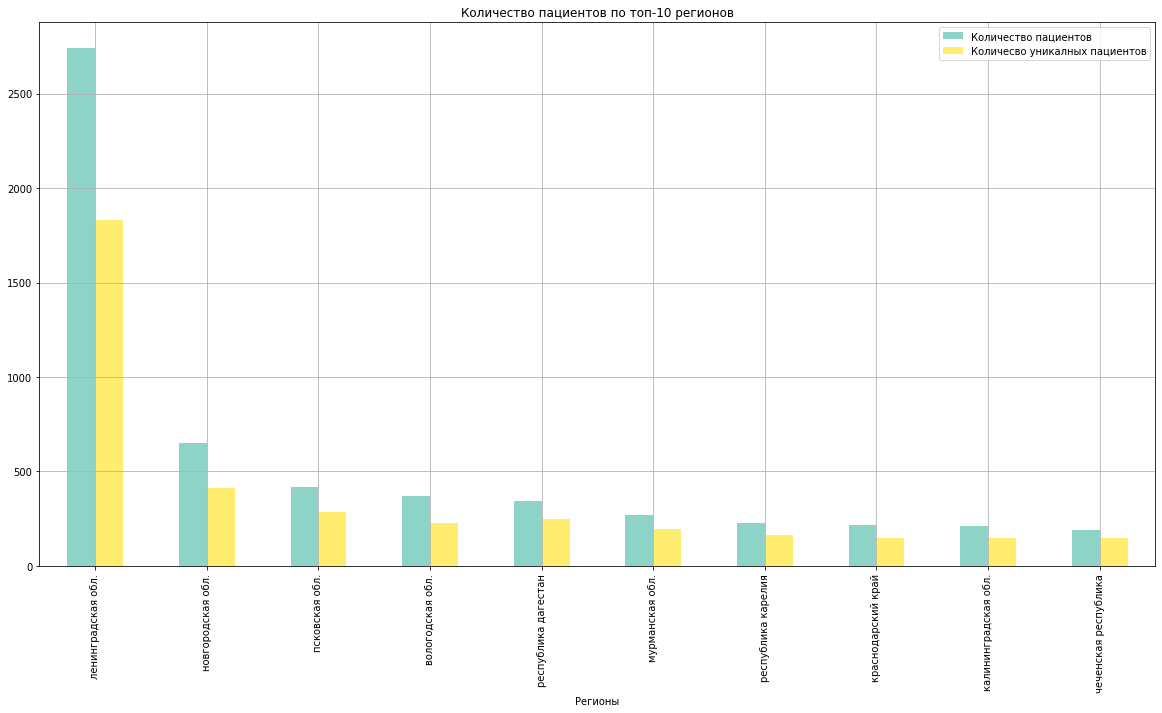

In [104]:
beds_zero_region_user = beds_zero_region_user.sort_values(by= 'count', ascending = False).head(10)
beds_zero_region_user[['count', 'nunique']].plot(kind = 'bar', colormap = 'Set3', figsize = (20, 10) )
plt.title('Количество пациентов по топ-10 регионов')
plt.legend(['Количество пациентов', 'Количесво уникалных пациентов'])
plt.grid()
#plt.xticks(np.arange(len(beds_zero_region_user)), beds_zero_region_user['region'])
plt.xlabel('Регионы')
plt.show()

In [105]:
beds_zero_fin_user= beds_zero.pivot_table(index = 'fin_source', values = 'user_id', aggfunc = ['count', 'nunique'])
beds_zero_fin_user.columns = ['count', 'nunique']
beds_zero_fin_user.sort_values(by = 'count', ascending = False)
# строим таблицу для оценки количества пациентов по источнику финансирования

,count,nunique
fin_source,,
ОМС,5733,4389
ВМП,2192,1579
Клинические апробации,194,161
Наличный расчет,26,26
ДМС,2,2


In [106]:
beds_zero_is_plan= beds_zero.pivot_table(index = 'is_plan', values = 'user_id', aggfunc = ['count', 'nunique'])
beds_zero_is_plan.columns = ['count', 'nunique']
beds_zero_is_plan
# строим таблицу для оценки количества пациентов по типу госпитализации

,count,nunique
is_plan,,
Плановая,8087,5619
Экстренная,60,55


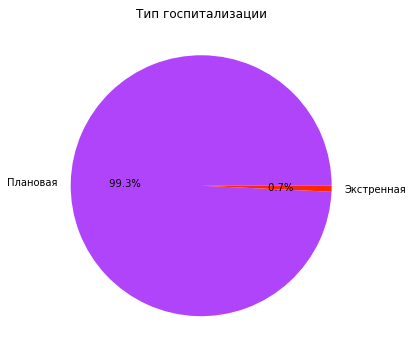

In [107]:
plt.figure(figsize = (12, 6))
labels = ['Плановая', 'Экстренная']
beds_zero_is_plan ['count'].plot(kind = 'pie', autopct =' %1.1f%%', labels=labels, colors = sns.color_palette('gist_ncar_r'))
plt.title ('Тип госпитализации')
plt.ylabel('')
plt.show()

In [108]:
beds_zero_dept = beds_zero.pivot_table(index = 'dept', values = 'user_id', aggfunc = ['count', 'nunique'])
beds_zero_dept.columns =  ['count', 'nunique']
beds_zero_dept.sort_values(by = 'count', ascending = False).head(10)
# строим таблицу для оценки количества пациентов по отделениям

,count,nunique
dept,,
Хирургическое отд. №1,1079,773
Педиатрическое отделение №3,997,601
Кожно-венерологическое отделение,924,398
Офтальмологическое,687,586
Педиатрическое отделение №1,628,376
Гастроэнтерологическое отделение,538,276
Психоневрологическое отд.,511,459
Отоларингологическое отделение,504,452
Эндокринологическое отд.,455,386


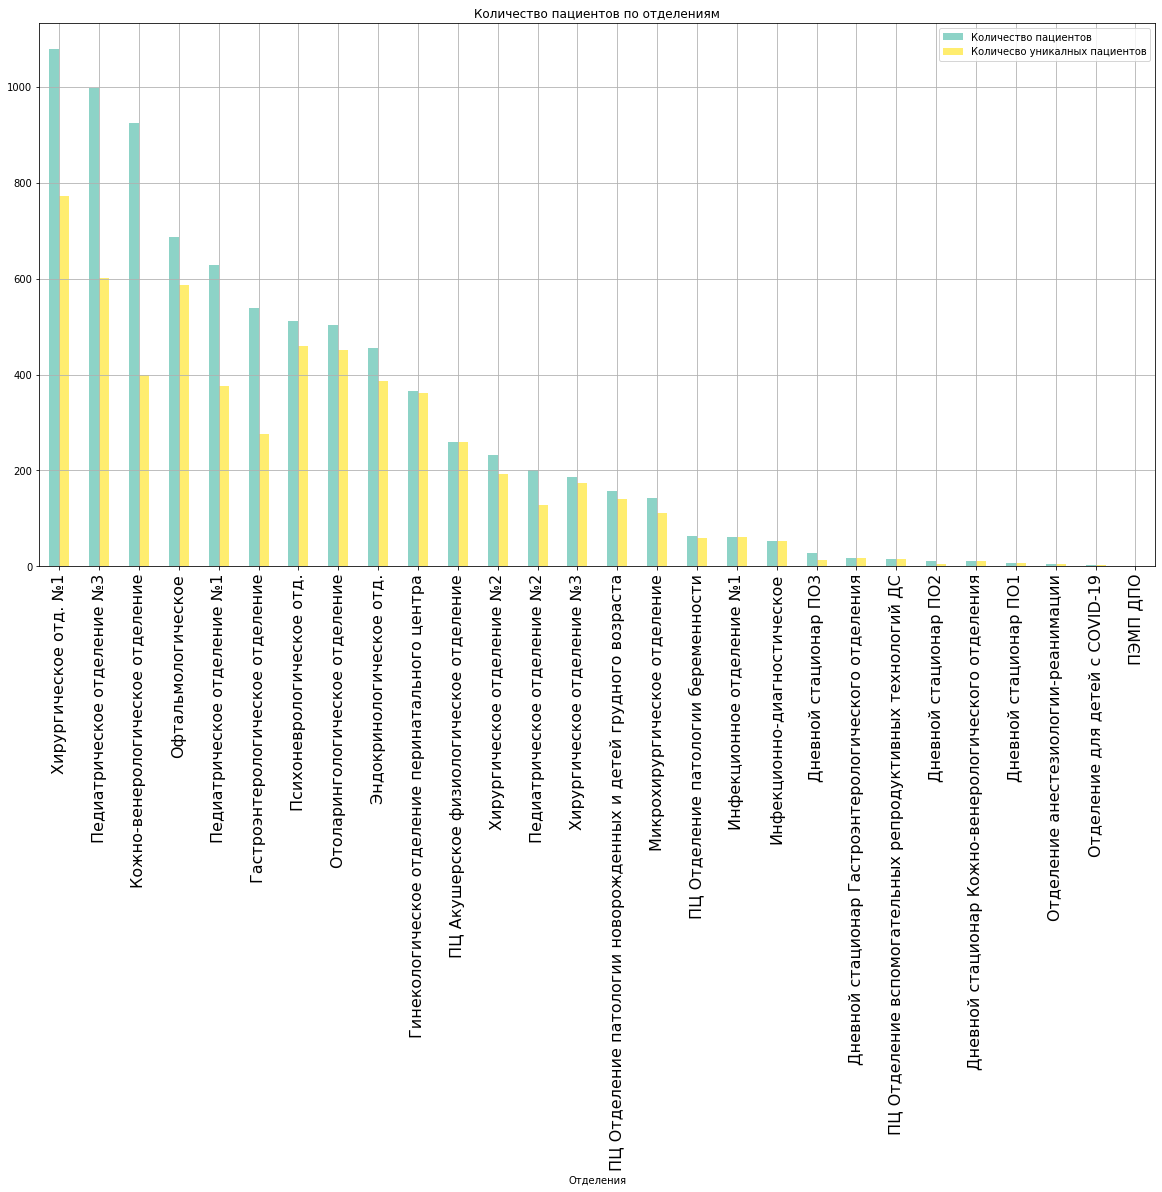

In [109]:
beds_zero_dept = beds_zero_dept.sort_values(by = 'count', ascending = False).reset_index()
beds_zero_dept [['count', 'nunique']].plot(kind = 'bar',colormap ='Set3', figsize = (20,10))
plt.title('Количество пациентов по отделениям')
plt.legend(['Количество пациентов', 'Количесво уникалных пациентов'])
plt.grid()
plt.xticks(np.arange(len(beds_zero_dept)), beds_zero_dept['dept'],fontsize=16)
plt.xlabel('Отделения')
plt.show()

Вывод. Выявлено 8146 пациентов с направлениями в день госпитализации. Большинство пациентов из Ленинграсдкой обл. Псуовской, Новгородской обл. т.е. Северо-Западный регион - место нахождения медицинского учреждения. 99% пациентов являются плановыми. Подавляющее большинство пациентов Хирургического, Педиатрического и кожно0венерологических отделений.

### Срок нахождения в стационаре

In [110]:
beds_new = pd.read_sql('SELECT * FROM beds;', con = beds_connection)
#обращаемся к первоначальной таблице

In [111]:
beds_new['bed_days'].describe()
# смотрим данные по времени лечения

count    179254.000000
mean          8.931081
std           9.346229
min           1.000000
25%           4.000000
50%           7.000000
75%          12.000000
max         427.000000
Name: bed_days, dtype: float64

Значения от -1 до 427 дней лечения

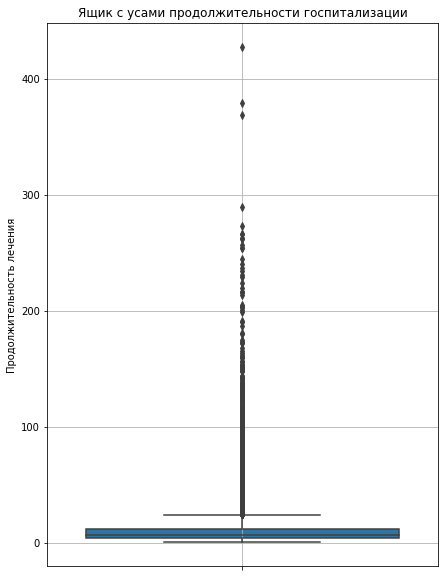

In [112]:
plt.figure(figsize = (7,10))
sns.boxplot(y = beds_new['bed_days'])
plt.title('Ящик с усами продолжительности госпитализации')
plt.ylabel('Продолжительность лечения')
plt.grid()
plt.show()

In [113]:
beds_copy_new = beds_new.dropna(subset = ['bed_days'])
beds_95_perc = round(np.percentile(beds_copy_new.bed_days, 95))
print ('95 % случаев лечения не превышает',beds_95_perc, 'дней' )
# расчитаем 95 перцентиль 

95 % случаев лечения не превышает 23 дней


In [114]:
beds_new_filter = beds_new.query('bed_days <= @beds_95_perc')
# уберем выбросы, превышающие 23 дня лечения

In [115]:
beds_new_filter['bed_days'].describe()
# проверяем

count    171097.000000
mean          7.593587
std           5.248874
min           1.000000
25%           4.000000
50%           7.000000
75%          11.000000
max          23.000000
Name: bed_days, dtype: float64

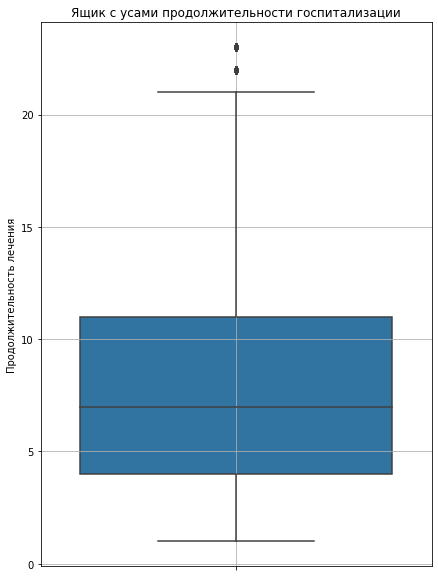

In [116]:
plt.figure(figsize = (7,10))
sns.boxplot(y = beds_new_filter['bed_days'])
plt.title('Ящик с усами продолжительности госпитализации')
plt.ylabel('Продолжительность лечения')
plt.grid()
plt.show()
# строим ящик с усами по очищенным данным

In [117]:
bed_days_corr = beds_new_filter[['referral_date', 'income_date', 'dept', 'is_plan', 'income_mkb', 'bed_days']]
# выделим факторы для корреляции

interval columns not set, guessing: ['bed_days']


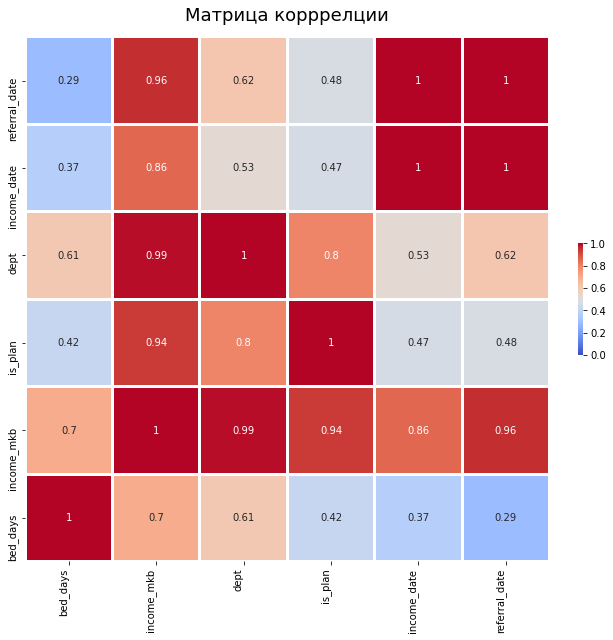

In [118]:
plt.figure(figsize = (10,10))
heatmap = sns.heatmap(bed_days_corr.phik_matrix().round(2).sort_values('bed_days', ascending = False, axis = 1),
                     annot = True, square = True, cmap = 'coolwarm', vmax = 1, vmin = 0, cbar_kws={'fraction': 0.01}, linewidth=2)

heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation = 90, horizontalalignment = 'right')
heatmap.set_title('Матрица корррелции', fontdict = {'fontsize': 18}, pad = 16)
plt.show()
# построим матрицу корреляции

Вывод. Видим среднюю корреляцию между сроком госпитализации и дагнозом при поступлении, среднюю корреляцию между отделением и сроком госпитализации. Слабая корреляция между сроком госпитализации и датой выдачи направления, а также датой госпитализации.

### Фактор смены диагноза

In [119]:
mkb =pd.read_excel('https://mkb10.su/download/mkb10.xlsx')
mkb.describe()
# загружаем таблицу с названиями диагнозов

,Международная классификация болезней Десятого пересмотра,Unnamed: 1,Unnamed: 2
count,12258,12257,12236
unique,12258,11181,1842
top,H93,"Лицо, пострадавшее при посадке или высадке",W00-X59
freq,1,54,33


In [120]:
mkb.rename(columns = {'Международная классификация болезней Десятого пересмотра':'mkb_cod', 'Unnamed: 1': 'mkb_name'}, inplace = True)
mkb.head(5)
# переименовываем названия столбцов

,mkb_cod,mkb_name,Unnamed: 2
0,NaN,NaN,NaN
1,Сайт: http://mkb10.su,NaN,NaN
2,Код диагноза,Название диагноза,Код родителя
3,A00-B99,Некоторые инфекционные и паразитарные болезни,NaN
4,A00-A09,Кишечные инфекции,A00-B99


In [121]:
mkb_names = mkb[['mkb_cod', 'mkb_name']]
mkb_names['income_mkb'] = mkb['mkb_cod']
beds_diagnos = beds_new.merge(mkb_names, on = 'income_mkb')
beds_diagnos.rename(columns = {'mkb_name': 'income_name'}, inplace = True)
beds_diagnos.drop(['mkb_cod'], axis = 1, inplace = True)
mkb_names['outcome_mkb'] = mkb['mkb_cod']
beds_diagnos = beds_diagnos.merge(mkb_names, on = 'outcome_mkb')
beds_diagnos.rename(columns = {'mkb_name': 'outcome_name', 'income_mkb_x':'income_mkb'}, inplace = True)
beds_diagnos.drop(['mkb_cod', 'income_mkb_y'], axis = 1, inplace = True)
beds_diagnos.head()
# объединяем таблицы, чтобы было видно название болезни, проверяем

,index,referral_date,income_date,outcome_date,user_id,is_num,code,region,payer,fin_source,dept,profile,bed_days,is_plan,income_mkb,outcome_mkb,income_name,outcome_name
0,0,None,01.01.2019,10.01.2019,8.580420e+08,1,5.4.1,None,"ОАО ""ГСМК"" СПб",ОМС,Микрохирургическое отделение,Сосудистой хирургии,10.0,Экстренная,S61.7,S66.4,Множественные открытые раны запястья и кисти,Травма собственной мышцы и сухожилия большого ...
1,20112,None,04.09.2019,05.09.2019,1.027052e+09,19111,5.7.1,None,"ООО СК ""Согласие-М"" Санкт-Петербургский филиал",ОМС,Микрохирургическое отделение,Сосудистой хирургии,1.0,Экстренная,S61.8,S66.4,Открытая рана других частей запястья и кисти,Травма собственной мышцы и сухожилия большого ...
2,63745,None,08.02.2021,08.02.2021,1.091988e+09,2663,5.5.1,None,"Филиал ОАО ""СОГАЗ"" в Санкт-Петербурге",ОМС,Микрохирургическое отделение,Сосудистой хирургии,1.0,Экстренная,S61.8,S66.4,Открытая рана других частей запястья и кисти,Травма собственной мышцы и сухожилия большого ...
3,123169,None,25.08.2022,25.08.2022,1.179051e+09,22978,5.666.0,Ленинградская обл.,ОМС 86 Регион,ОМС,Микрохирургическое отделение,Сосудистой хирургии,1.0,Экстренная,S61.8,S66.4,Открытая рана других частей запястья и кисти,Травма собственной мышцы и сухожилия большого ...
4,24001,None,13.10.2019,13.10.2019,3.009940e+08,22797,5.12.1,None,"ООО ""Капитал Медицинское Страхование""",ОМС,Микрохирургическое отделение,Сосудистой хирургии,1.0,Экстренная,S61.0,S66.4,Открытая рана пальца(ев) кисти без повреждения...,Травма собственной мышцы и сухожилия большого ...


In [122]:
for col in ['referral_date', 'income_date','outcome_date']:
    beds_diagnos[col] = pd.to_datetime(beds_diagnos[col], dayfirst = True)
# приводим типов данных по дате к корректным

In [123]:
beds_diagnos['income_month'] = beds_diagnos['income_date'].dt.month
beds_diagnos['income_year'] = beds_diagnos['income_date'].dt.year
beds_diagnos.head(2)
# добавляем столбец год и месяц поступления, проверяем

,index,referral_date,income_date,outcome_date,user_id,is_num,code,region,payer,fin_source,dept,profile,bed_days,is_plan,income_mkb,outcome_mkb,income_name,outcome_name,income_month,income_year
0,0,NaT,2019-01-01,2019-01-10,8.580420e+08,1,5.4.1,None,"ОАО ""ГСМК"" СПб",ОМС,Микрохирургическое отделение,Сосудистой хирургии,10.0,Экстренная,S61.7,S66.4,Множественные открытые раны запястья и кисти,Травма собственной мышцы и сухожилия большого ...,1,2019
1,20112,NaT,2019-09-04,2019-09-05,1.027052e+09,19111,5.7.1,None,"ООО СК ""Согласие-М"" Санкт-Петербургский филиал",ОМС,Микрохирургическое отделение,Сосудистой хирургии,1.0,Экстренная,S61.8,S66.4,Открытая рана других частей запястья и кисти,Травма собственной мышцы и сухожилия большого ...,9,2019


In [124]:
conditions = [beds_diagnos['income_name'] == beds_diagnos['outcome_name'],
            beds_diagnos['income_name'] != beds_diagnos['outcome_name']]
choice = [0,1]
beds_diagnos['change'] = np.select(conditions, choice, default = 'Tie')

In [125]:
beds_diagnoss = beds_diagnos.pivot_table(index = 'change', values = 'index', aggfunc = 'count')
beds_diagnoss['share']= round(beds_diagnoss['index']/(beds_diagnoss['index'].sum())*100,1)
beds_diagnoss = beds_diagnoss.rename(columns = {'index': 'count'})
beds_diagnoss
# таблица для наглядной оценки смены диагноза

,count,share
change,,
0,98640,57.5
1,72908,42.5


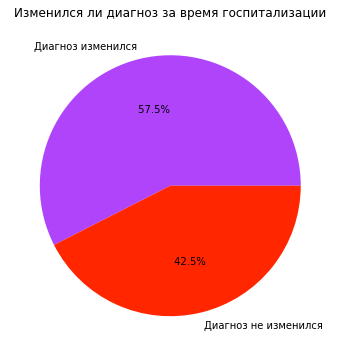

In [126]:
plt.figure(figsize = (12, 6))
labels = ['Диагноз изменился', 'Диагноз не изменился']
beds_diagnoss ['count'].plot(kind = 'pie', autopct =' %1.1f%%', labels=labels, colors = sns.color_palette('gist_ncar_r'))
plt.title ('Изменился ли диагноз за время госпитализации')
plt.ylabel('')
plt.show()
# график изменения диагноза наглядно

Вывод. В большинстве случаев диагноз меняется во время лечения.

### Сезонность заболеваний

#### Заболеваемость по месяцам

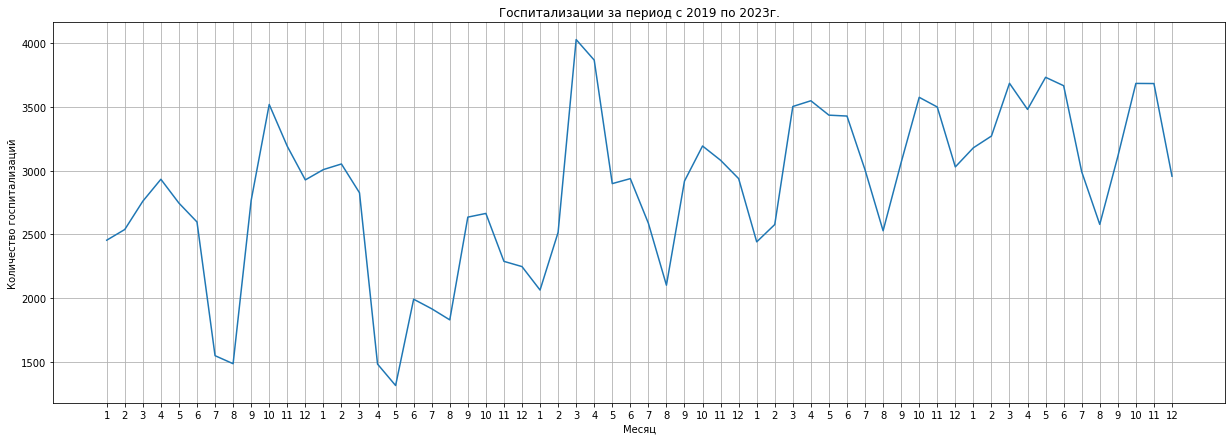

In [127]:
income_pivot_complete = beds_diagnos.pivot_table(index = ['income_year', 'income_month'], 
                                           values = 'index', aggfunc = 'count')
income_complete = income_pivot_complete.reset_index()

income_complete['index'].plot(figsize = (21, 7), grid = True, legend = False)
plt.xticks(np.arange(len(income_complete)), income_complete['income_month'])
plt.title('Госпитализации за период с 2019 по 2023г.')
plt.xlabel('Месяц')
plt.ylabel('Количество госпитализаций')
plt.show()
# график госпитализации по месяцам

In [128]:
income_pivot_years = beds_diagnos.pivot_table(index = 'income_month', columns = 'income_year', 
                                              values = 'index', aggfunc = 'count') 
income_pivot_years

income_year,2019,2020,2021,2022,2023
income_month,,,,,
1,2455,3009,2064,2442,3180
2,2539,3053,2516,2578,3272
3,2761,2827,4029,3504,3686
4,2933,1483,3868,3549,3481
5,2746,1315,2899,3436,3733
6,2598,1992,2938,3429,3667
7,1549,1917,2588,3007,2992
8,1486,1830,2102,2529,2579
9,2767,2636,2919,3065,3112


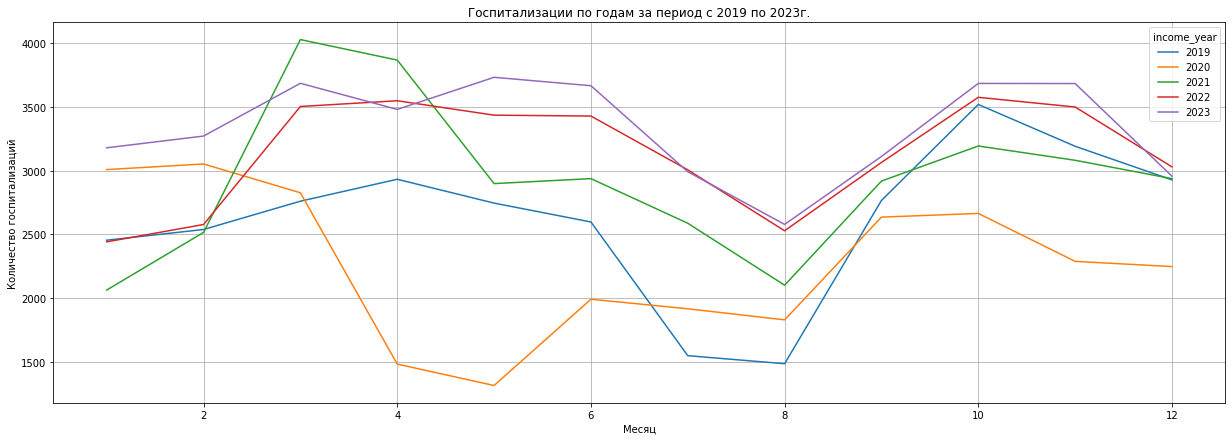

In [129]:
income_pivot_years.plot(figsize = (21, 7), grid = True)
plt.title('Госпитализации по годам за период с 2019 по 2023г.')
plt.xlabel('Месяц')
plt.ylabel('Количество госпитализаций')
plt.show()

Вывод. Заболеваемость ниже в 2019-2020 годы. Связано с COVID 19. Пики заболеваемости в марте и октября. самая низкая заболеваемость январь - декабрь.

#### Группы диагнозов по сезонам

## Корреляция

In [130]:
beds['group_bin'] = pd.qcut(beds['waiting'].rank(method = 'first'), 10)
# разобьем длительность на 10 примерно равных группп

In [131]:
beds_corr = beds[['referral_date', 'income_date', 'region', 'payer', 'fin_source', 'dept', 'profile',
                 'is_plan', 'income_mkb','group_bin']]
# выделим факторы для корреляции

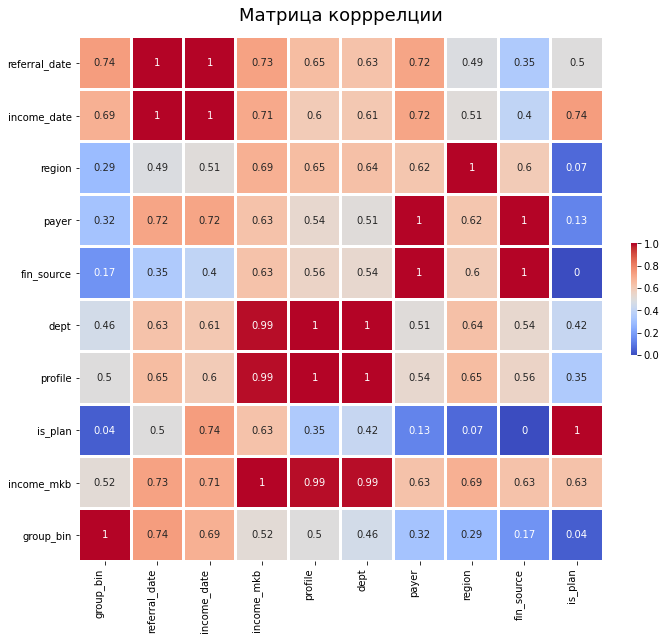

In [132]:
plt.figure(figsize = (10,10))
heatmap = sns.heatmap(beds_corr.phik_matrix().round(2).sort_values('group_bin', ascending = False, axis = 1),
                     annot = True, square = True, cmap = 'coolwarm', vmax = 1, vmin = 0, cbar_kws={'fraction': 0.01}, linewidth=2)

heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation = 90, horizontalalignment = 'right')
heatmap.set_title('Матрица корррелции', fontdict = {'fontsize': 18}, pad = 16)
plt.show()
# построим матрицу корреляции

Выводы. Наблюдается высокая корреляция между длительностью ожидания и датой выдачи направления, датой госпитализации. Средня зависимость между длительнсотью и дигнозом, отделением. Слабая корреляция между длительностью ожидания и регионом, источником финансирования.

## Проверка гипотез

### Длительность ожидания госпитализации по Ленинградской области и иным регионам

H0: Средняя продолжительность ожидания госпитализации с момента выдачи направления по Лен. обл. и другим направлениям равны

H1: Средняя продолжительность ожидания госпитализации с момента выдачи направления по Лен. обл. и другим направлениям НЕ равны

In [133]:
beds_lo = beds.query('region == "ленинградская обл."' )
beds_other = beds.query('region != "ленинградская обл."' )

lo = beds_lo['waiting']
other = beds_other['waiting']

alpha = 0.05 # уровень статистической значимости
# если p-value окажется меньше него, отвергнем гипотезу

results = st.ttest_ind(lo, other, equal_var = False)
print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не отвергаем нулевую гипотезу')

p-значение: 1.5958220401773595e-135
Отвергаем нулевую гипотезу


Вывод: Средняя продолжительность между выдачей направления и датой госпитализации по Ленинградской области и другими регионами НЕ равна

### Длительность ожидания госпитализации по Чеченской респ. и иным регионам

H0: Средняя продолжительность ожидания госпитализации с момента выдачи направления по Чеченской респ. и другим направлениям равны

H1: Средняя продолжительность ожидания госпитализации с момента выдачи направления по Чеченской респ. и другим направлениям НЕ равны

In [134]:
beds_che = beds.query('region == "чеченская республика"' )
beds_no_che = beds_other.query('region != "чеченская республика"' )

che = beds_che['waiting']
other = beds_no_che['waiting']

alpha = 0.05 # уровень статистической значимости
# если p-value окажется меньше него, отвергнем гипотезу

results = st.ttest_ind(che, other, equal_var = False)
print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не отвергаем нулевую гипотезу')

p-значение: 1.1466467601393613e-09
Отвергаем нулевую гипотезу


Вывод: Средняя продолжительность между выдачей направления и датой госпитализации по Чеченской респ. и другими регионами (исключая Ленинградскую область) НЕ равна

### Длительность ожидания по ОМС и иным источникам финансирования

H0: Средняя продолжительность ожидания госпитализации с момента выдачи направления по ОМС и другим источникам финансирования равны

H1: Средняя продолжительность ожидания госпитализации с момента выдачи направления по ОМС и другим источникам финансирования НЕ равны

In [135]:
beds_oms = beds.query('fin_source == "ОМС"' )
beds_other = beds.query('fin_source != "ОМС"' )

oms = beds_oms['waiting']
other = beds_other['waiting']

alpha = 0.05 # уровень статистической значимости
# если p-value окажется меньше него, отвергнем гипотезу

results = st.ttest_ind(oms, other, equal_var = False)
print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не отвергаем нулевую гипотезу')

p-значение: 9.100291670229484e-97
Отвергаем нулевую гипотезу


Вывод: Средняя продолжительность между выдачей направления и датой госпитализации по ОМС и иным источникам финансирования НЕ равна

## Вывод 

В данном проекте  выполнена загрузка даннных. В ходе изучения и подготовки данных, мы получили следующую информацию. В представленном файле 179559 строк, явных дубликатов нет, столбцы с датами приведены к корректным. В данных довольно таки много пропусков, в том числе в Дате выдачи направления и user_id
Мы удалили неявные дубликаты. Неявные дубликаты в названиях регионов обработаны и приведены к единому стандарту. Страны разделены на ближнее и дальнее зарубежье.

Во время исследовательского анализа определили длительность ожидания госпитализации после выдачи направления. В данных мед. учреждения представлены данные за период с 01 января 2019 по 30 декабря 2023. Записи по пациентам, срок ожидания госпитализации у которых более года - удалены. В данных есть выбросы, но по просьбе заказчика удаляли только превышающие 365 дней.

Количество уникальных пациентов 45364

Мы исследовали несколько факторов, влияющих на продолжительность ожидания госпитализации

Фактор плановая/экстренная госпитализация. Менее 1% пациентов попадает на лечение экстренно.

Фактор региона. Большинство пациентов из Ленинградской области. Топ-6 по количеству пациентов приходится на жителей Северо-Западного ФО. Медианное время ожидания госпитализации у жителей Лен. области чуть ниже, чем у остальных регионов Северо-запада. Бросается в глаза низкое время ожидания госпиализации жителей Чеченской респ. В далнейшем мы проверили гипотезу о разнице ожидания госпитализации жителей Чеченской респ. и других регионов.

Фактор источника финансирования и плательщика тесно связаны. Абсолютное большинство обращений - это обращения по ОМС. Но также медианное значение длительности ожидания по этой категории выше, чем по другим. Также мы проверили гипотезу о том, что для пациентов, обращающихся по ОМС, срок ожидания выше.

Фактор диагноза Коэффициент кореляции между кол-вом пациентов и средней длительностью ожидания довольно-таки слабый.

Фактор месяца выдачи направлений.  Пик длительности ожидания наблюдается по направлениям, выданным в апреле, после идет на спад до декабря и резко возрастает в декабре. Количество выданых направлений резко возрастает в августе и растет до декабря

Фактор месяца госпитализации. Больше всего госпитализаций в октябре-ноябре, меньше всего в декабре и январе и апреле

Случаев, когда направление было выдано после госпитализации всего 5. Срок от 1 до 28 дней. Это регионы Архангельская обл., Коми, Дагестан, Псковская обл. Все случаи плановой госпитализации. Выявлено 8146 пациентов с направлениями в день госпитализации. Большинство пациентов из Ленинграсдкой обл. Псковской, Новгородской обл. т.е. Северо-Западный регион - место нахождения медицинского учреждения. 99% пациентов являются плановыми. Подавляющее большинство пациентов Хирургического, Педиатрического и кожно-венерологических отделений.

По сроку госпитализации модно сделать вывод, что пациенты в среднем находятся на лечении около 7 дней.
Видим среднюю корреляцию между сроком госпитализации и дагнозом при поступлении, среднюю корреляцию между отделением и сроком госпитализации. Слабая корреляция между сроком госпитализации и датой выдачи направления, а также датой госпитализации. Также в большинстве случаев диагноз меняется во время лечения.

Заболеваемость ниже в 2019-2020 годы. Связано с COVID 19. Пики заболеваемости в марте и октября. самая низкая заболеваемость январь - декабрь.

Проверив гипотезы, мы пришли к выводу, что Средняя продолжительность между выдачей направления и датой госпитализации по Ленинградской области и другими регионами не равна. По Лен. области этот срок ниже.
Средняя продолжительность между выдачей направления и датой госпитализации по Чеченской респ. и другими регионами (исключая Ленинградскую область) также равна. Средняя продолжительность между выдачей направления и датой госпитализации по ОМС и иным источникам финансирования НЕ равна

